**ReadMe:**

- To get the result of test error, please scroll down to the bottom, find the Section 7 (Final Model), and run all the cells below it.
- The other parts may contain processes for hyperparameter tuning, so please run them carefully.
- Detailed explanations about how we construct and tune each model are provided in each corresponding section (but not in the last section).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import random as python_random

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Set seed
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# 1. Exploratory Data Analysis (EDA)

## 1.1 Descriptive Statstics

In [3]:
# Import the data
data = pd.read_csv('CPI_train.csv')
data.head()

,Quarter,CPI
0,1990-03-01,43.513571
1,1990-06-01,43.993571
2,1990-09-01,44.593571
3,1990-12-01,46.633571
4,1991-03-01,48.673571


In [4]:
print('Number of data points:', data.shape[0])
print()

print('Time span:', data['Quarter'].iloc[0], '-', data['Quarter'].iloc[-1])
print()

print('Number of missing values:')
print(data.isna().sum())
print()

print('Number of duplicated rows:', data.duplicated().sum())
print()

print('Data types:')
print(data.dtypes)
print()

Number of data points: 124

Time span: 1990-03-01 - 2020-12-01

Number of missing values:
Quarter    0
CPI        0
dtype: int64

Number of duplicated rows: 0

Data types:
Quarter     object
CPI        float64
dtype: object



In [5]:
# Set the time index
data['Quarter'] = pd.to_datetime(data['Quarter'])  # convert the Quarter column into datetime
data.set_index('Quarter', inplace=True)  # set the Quarter column as the index
data.head()

,CPI
Quarter,
1990-03-01,43.513571
1990-06-01,43.993571
1990-09-01,44.593571
1990-12-01,46.633571
1991-03-01,48.673571


## 1.2 Visualization

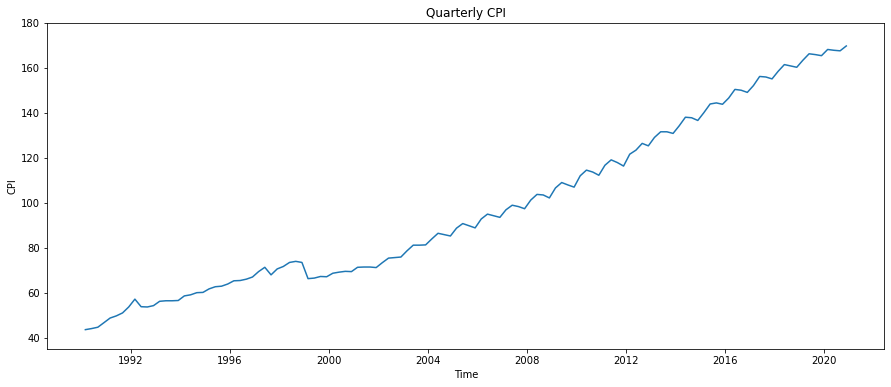

In [6]:
cpi = data['CPI']

# Plot the data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Quarterly CPI')
plt.ylim(35, 180)
plt.show()

**1. Trend:** There is an increasing linear trend component.

**2. Seasonality:** The seasonal component starts to appear around 2000 with frequency = 4 (because this is quarterly data).

**3. Seasonal variation:** The variation of the seasonal component is relatively smaller at the time it starts to appear. But after 2004, it almost remains unchanged until the end of 2020. This indicates an additive model may be more suitable for this data.

**4. Stationarity:** The data is not stationary because there is an obvious trend component, which indicates the mean of the data is not constant over time.

It is worth noticing that the pattern of the data significantly changes after 2000. As a result, in the following implementation section, we also examine the forecasting ability of different methods by discarding the data before 2000 and compare them with the ones using the whole data.

# 2. Preprocessing

## 2.1 Train-test-split

To compare the performance of different forecast methods, we use the last 8 data points in the `cpi` as the validation set, and the rest of the data is the training set.

In [7]:
# Use the last 8 data points as the validation set
train = cpi[:-8]
valid = cpi[-8:]

print('Number of data points in the training set:', len(train))
print('Number of data points in the validation set:', len(valid))

Number of data points in the training set: 116
Number of data points in the validation set: 8


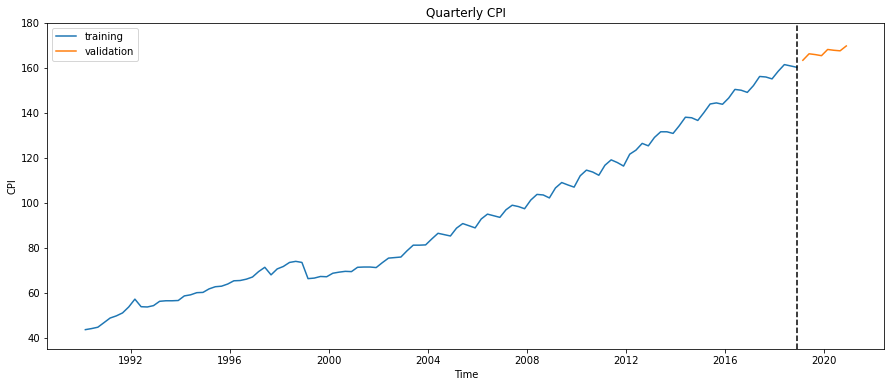

In [8]:
# Plot the training and validation data
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(valid)
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Quarterly CPI')
plt.legend(['training', 'validation'], loc=2)
plt.ylim(35, 180)
plt.show()

## 2.2. Evaluation Metric

The evaluation metrics we used to compare the performance of different forecast methods are **mean suqared error (MSE)**, **mean absolute percentage error (MAPE)**, and **Akaike information criterion (AIC)**.

The first two criteria are calculated only based on the validation set, while the last one is caculated based on the training data.

In [9]:
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [10]:
def MAPE(y_true,y_pred):
    # Ignore zero returns
    y_true_non_zero = y_true[y_true != 0]
    y_pred_non_zero = y_pred[y_pred != 0]
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

# 4. Forecasting

## 4.1 Time Series Decomposition

According to the visual analysis, we know that the data is more suitable for a additive model. Hence, an additive decomposition model was chosen for forecasting.

### 4.1.1 Model Construction

In [11]:
# Estimate the trend component using CMA-4
trend_est = train.rolling(4, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Estimate the seasonal component
detrended = train - trend_est                         # compute the detrended data
detrended_zero = np.nan_to_num(detrended)             # replace the missing values by zeros
detrended_zero = detrended_zero.reshape((-1, 4))
quaterly_avg = np.mean(detrended_zero[1:28], axis=0)  # calculate the quaterly average (exclude first and last year)
seasonal_idx = quaterly_avg - quaterly_avg.mean()     # normalize theseasonal indices
seasonal_est = np.tile(seasonal_idx, len(train)//4)   # replicate the seasonal indices

In [12]:
# Re-estimate the trend component by modeling
seasonal_adjusted = train - seasonal_est  # compute the seasonally adjusted data

train_time = np.arange(1, len(train)+1)    
X_train_tsd = train_time.reshape((-1, 1))  # define the input data of the training set
y_train_tsd = seasonal_adjusted            # define the target data of the training set

lr = OLS(y_train_tsd, add_constant(X_train_tsd)).fit()  # fit a linear regression model
trend_model = lr.predict(add_constant(X_train_tsd))     # compute the fitted trend component
tsd_fitted = trend_model + seasonal_est                 # compute the fitted values of the training data

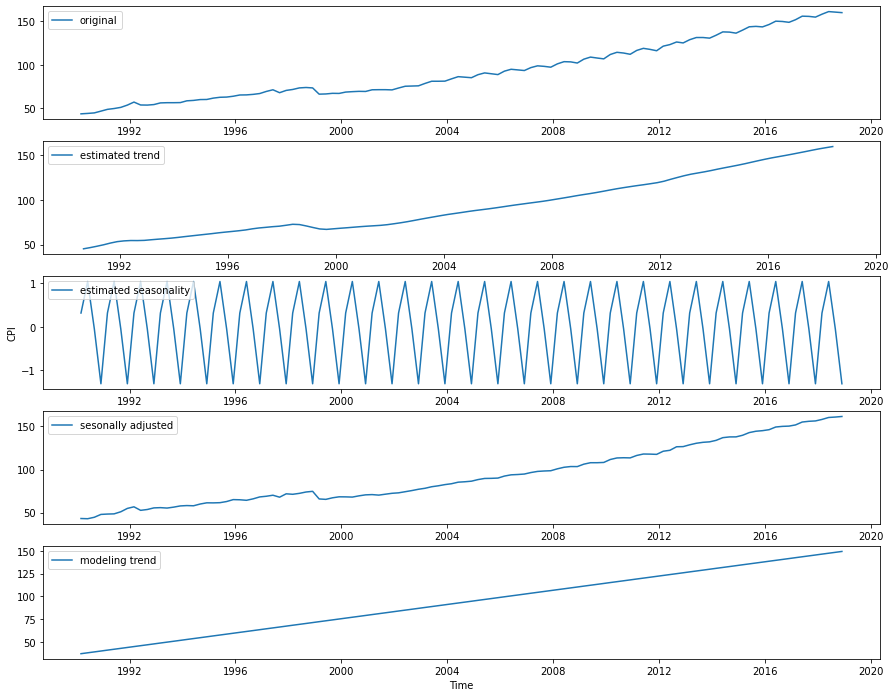

In [13]:
# Plot the fitted results
fig, ax = plt.subplots(5, 1, figsize=(15,12))
ax[0].plot(train.index, train)
ax[1].plot(train.index, trend_est)
ax[2].plot(train.index, seasonal_est)
ax[3].plot(train.index, seasonal_adjusted)
ax[4].plot(train.index, trend_model)
ax[0].legend(['original'], loc=2)
ax[1].legend(['estimated trend'], loc=2)
ax[2].legend(['estimated seasonality'], loc=2)
ax[3].legend(['sesonally adjusted'], loc=2)
ax[4].legend(['modeling trend'], loc=2)
plt.xlabel('Time')
ax[2].set_ylabel('CPI')
ax[1].set_xlim(datetime.strptime('1989-03-01', '%Y-%m-%d'), datetime.strptime('2020-03-01', '%Y-%m-%d'))
plt.show()

### 4.1.2 Forecast Result

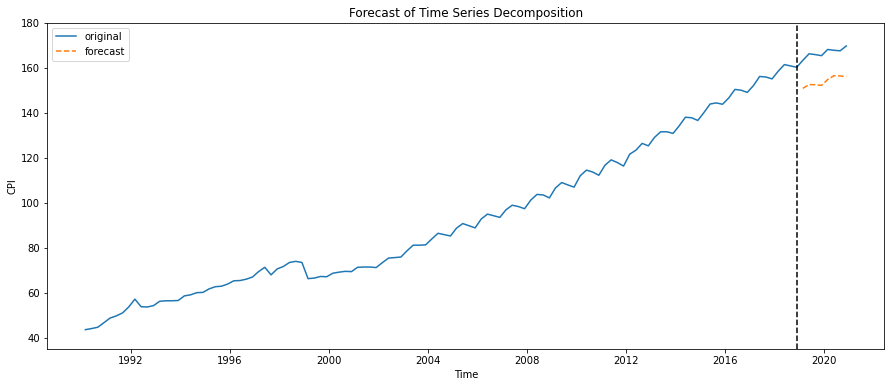

In [14]:
# Forecast the data after 2018
valid_time = np.arange(len(train)+1, len(train)+9)
X_valid_tsd = valid_time.reshape(-1, 1)                 # define the input data of the validation set
trend_forecast = lr.predict(add_constant(X_valid_tsd))  # forecast the trend component
seasonal_forecast = np.tile(seasonal_idx, 2)            # forecast the seasonal component
tsd_forecast = trend_forecast + seasonal_forecast       # add the forcasted trend and seasonal component

# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, tsd_forecast, '--')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Time Series Decomposition')
plt.legend(['original', 'forecast'], loc=2)
plt.ylim(35, 180)
plt.show()

In [15]:
# Calculate the MSE and MAPE of the forecast
tsd_mse = MSE(valid, pd.Series(tsd_forecast).set_axis(valid.index))
tsd_mape = MAPE(valid, pd.Series(tsd_forecast).set_axis(valid.index))
tsd_aic = lr.aic

print("MSE of time series decomposition: {:.4f}".format(tsd_mse))
print("MAPE of time series decomposition: {:.4f}%".format(tsd_mape))
print("AIC of time series decompostion: {:.4f}".format(tsd_aic))

MSE of time series decomposition: 164.4243
MAPE of time series decomposition: 7.6729%
AIC of time series decompostion: 788.1189


### 4.1.3 Residual Diagonstics

Since the procross of modelling the trend component involves fitting a linear regression model, residual diagnostics is run to assess the validility of the fitted model and check the assumptions.

**1. Residual plot against predictors/fitted values**: check whether the data follows a linear relationship/ the residuals follow homoscedasticity.

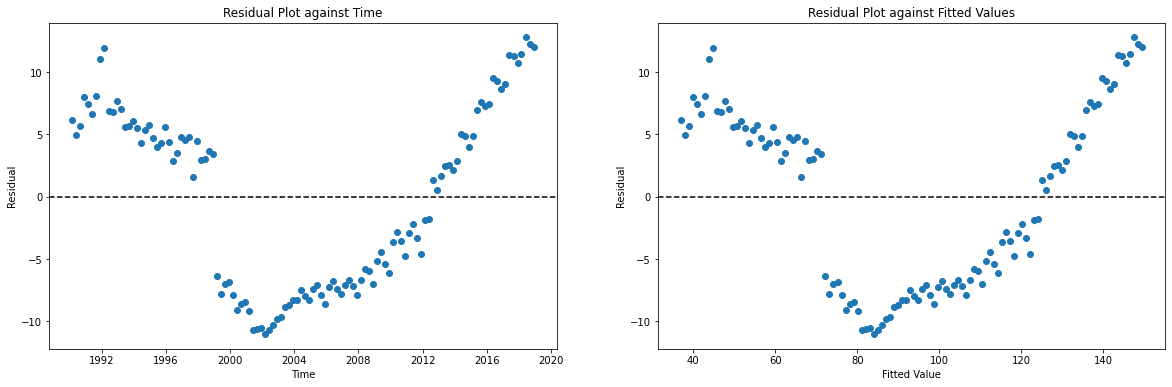

In [16]:
# Compute the residuals
tsd_res = seasonal_adjusted - trend_model

# Plot the residuals against the time variable and fitted values
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].scatter(train.index, tsd_res)
ax[1].scatter(trend_model, tsd_res)
ax[0].axhline(y=0, color='black', ls='--')
ax[1].axhline(y=0, color='black', ls='--')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Fitted Value')
ax[0].set_ylabel('Residual')
ax[1].set_ylabel('Residual')
ax[0].set_title('Residual Plot against Time')
ax[1].set_title('Residual Plot against Fitted Values')
plt.show()

**2. ACF/PACF plot:** check the autocorrelation in the residuals.

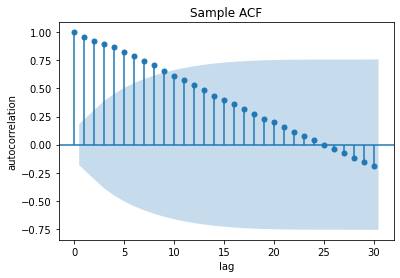

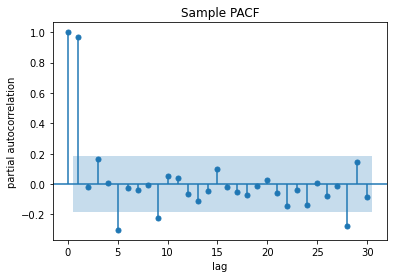

In [17]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(tsd_res, lags=30, alpha=0.05)
plt.title('Sample ACF')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(tsd_res, lags=30, alpha=0.05)
plt.title('Sample PACF')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.show()

**3. Histogram of residuals:** check whether the residuals are normally distributed.

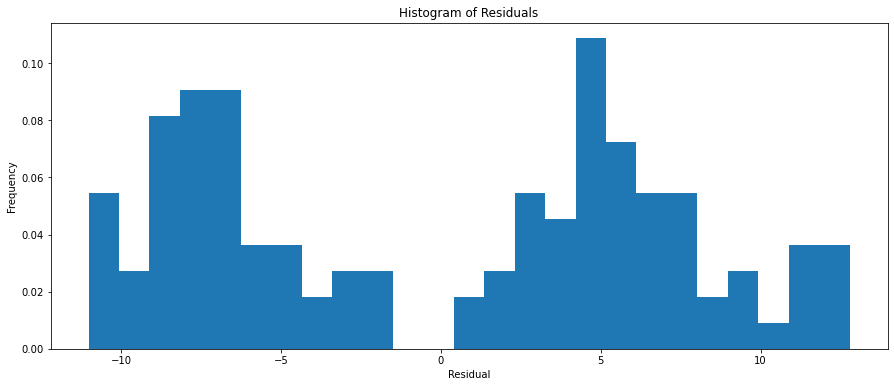

In [18]:
# Plot the histogram of the residuals
plt.figure(figsize=(15,6))
plt.hist(tsd_res, bins=25, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The results show that the linear regression model does not quite fit the seasonally adjusted CPI data. Both residual plots show a clear pattern, indicating the data does not follow a linear relationship, and the residuals does not follow the assumption of constant variance (homoscedasticity). Besides, it can be observed from the PACF plot that there are still some peaks even after lag 20, and the histogram also shows that residuals do not follow the normal distribution, either. As a result, it can be concluded that the linear regression model may not be suitable for modeling such data.

## 4.2 Linear Regression

To model the CPI data using a linear regression model, it requires four variables: (1) **one time varaible** for the trend component and (2) **three seasonal dummy variables** for the seasonal component. Note that we only need three dummy variables because only one fewer variables of the seasonal frequency (= 4 for CPI data) should be used to prevent dummy variable trap.

### 4.2.1 Model Construction

In [19]:
# Create seasonal dummy variables
seasons = []
for i in range(len(cpi)):
    if i % 4 == 0:
        seasons = np.append(seasons, 'Q1')
    if i % 4 == 1:
        seasons = np.append(seasons, 'Q2')
    if i % 4 == 2:
        seasons = np.append(seasons, 'Q3')
    if i % 4 == 3:
        seasons = np.append(seasons, 'Q4')
        
seasonal_dummy = pd.get_dummies(seasons, drop_first=True)
seasonal_dummy.head()

,Q2,Q3,Q4
0,0,0,0
1,1,0,0
2,0,1,0
3,0,0,1
4,0,0,0


In [20]:
# Define the input and target data of the traning set
X_train_lr = np.hstack((seasonal_dummy[:len(train)], train_time.reshape(-1, 1)))  # add the time variable
y_train_lr = train

# Fit a linear regression model
lr = OLS(y_train_lr, add_constant(X_train_lr)).fit()

# Print the fitted results
print(lr.summary())

# Compute the fitted values of the training data
lr_fitted = lr.predict(add_constant(X_train_lr))

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     588.9
Date:                Sun, 28 May 2023   Prob (F-statistic):           9.66e-74
Time:                        16:51:55   Log-Likelihood:                -392.05
No. Observations:                 116   AIC:                             794.1
Df Residuals:                     111   BIC:                             807.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.2980      1.772     20.489      0.0

### 4.2.2 Forecast Result

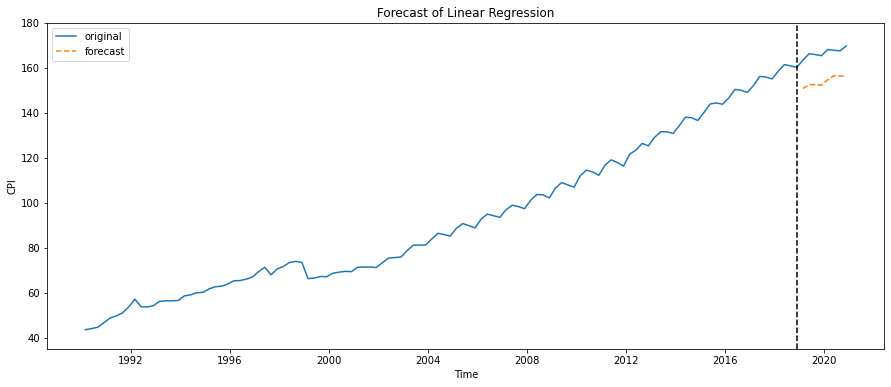

In [21]:
# Forecast the data after 2018
X_valid_lr = np.hstack((seasonal_dummy[len(train):], valid_time.reshape(-1, 1)))  # define the input data of the validation set
lr_forecast = lr.predict(add_constant(X_valid_lr))

# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, lr_forecast, '--')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Linear Regression')
plt.legend(['original', 'forecast'], loc=2)
plt.ylim(35, 180)
plt.show()

In [22]:
# Calculate the MSE and MAPE of the forecast
lr_mse = MSE(valid, pd.Series(lr_forecast).set_axis(valid.index))
lr_mape = MAPE(valid, pd.Series(lr_forecast).set_axis(valid.index))
lr_aic = lr.aic

print("MSE of linear regression: {:.4f}".format(lr_mse))
print("MAPE of linear regression: {:.4f}%".format(lr_mape))
print("AIC of time series decompostion: {:.4f}".format(lr_aic))

MSE of linear regression: 164.4997
MAPE of linear regression: 7.6755%
AIC of time series decompostion: 794.1075


### 4.2.3 Residual Diagnostics

We also run the residual diagnostics to check whether a linear regression model is appropriate for the CPI data.

**1. Residual plot against predictors/fitted values**: check whether the data follows a linear relationship/ the residuals follow homoscedasticity.

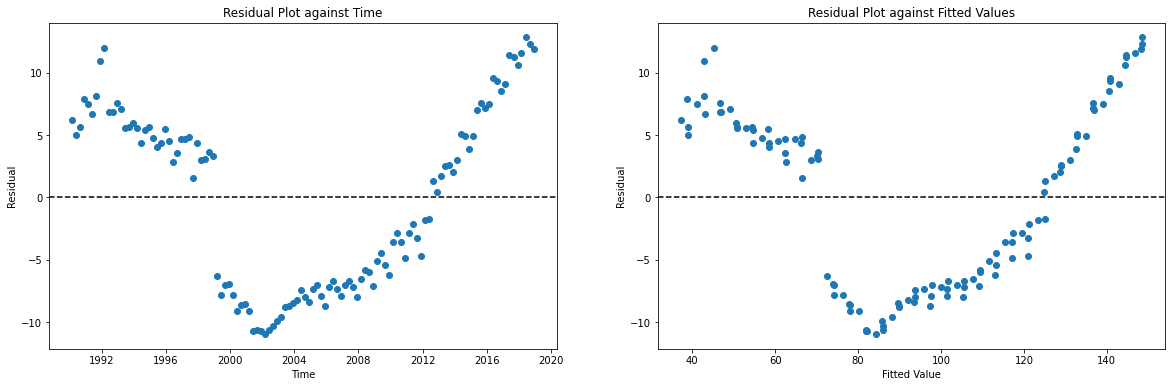

In [23]:
# Compute the residuals
lr_res = train - lr_fitted

# Plot the residuals against the time variable and fitted values
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].scatter(train.index, lr_res)
ax[1].scatter(lr_fitted, lr_res)
ax[0].axhline(y=0, color='black', ls='--')
ax[1].axhline(y=0, color='black', ls='--')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Fitted Value')
ax[0].set_ylabel('Residual')
ax[1].set_ylabel('Residual')
ax[0].set_title('Residual Plot against Time')
ax[1].set_title('Residual Plot against Fitted Values')
plt.show()

**2. ACF/PACF plot:** check the autocorrelation in the residuals.

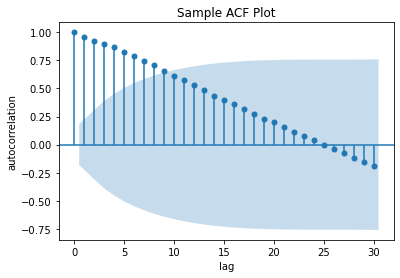

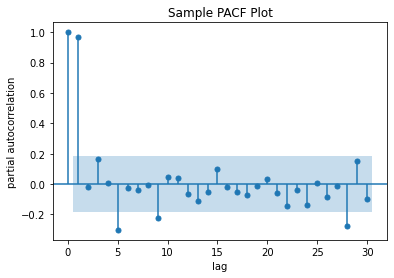

In [24]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(lr_res, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(lr_res, lags=30, alpha=0.05)
plt.title('Sample PACF Plot')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.show()

**3. Histogram of residuals:** check whether the residuals are normally distributed.

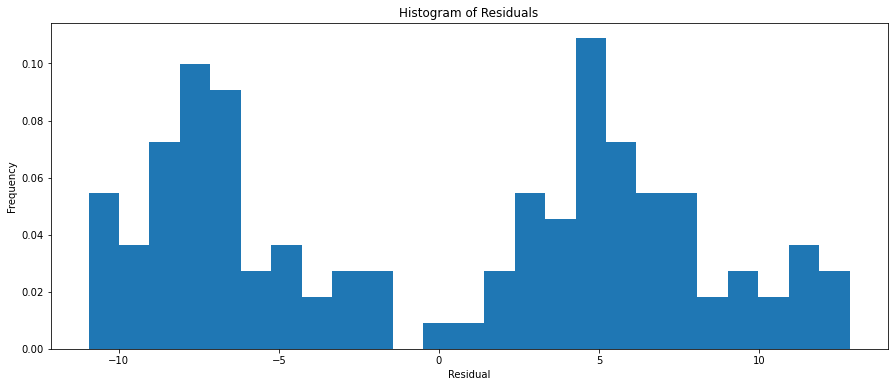

In [25]:
# Check the distribution of the residuals
plt.figure(figsize=(15,6))
plt.hist(lr_res, bins=25, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Similar to the reuslts of the time series decomposition method, the diagnostics results we get here again show that it is not appropriate to use a linear regression model to model the CPI data. There are clear pattenrs shown in the residual plots, and the autocorrelation of the residuals is relatively strong. In addition, it is obvious that the distribution of the residuals does not follow the normal assumption. Hence, this explains why the forecasting result obtained using the linear regression model are not that accurate.

## 4.3 Holt-Winters Exponential Smoothing

Since the CPI data contains a trend and seasonal component, we use Holt-Winters exponential smoothing method, which can handle both components in the data simultaneously, to make forecast.

### 4.3.1 Model Construction

In [26]:
# Fit a Holt-Winters exopnential smoothing model
hw = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


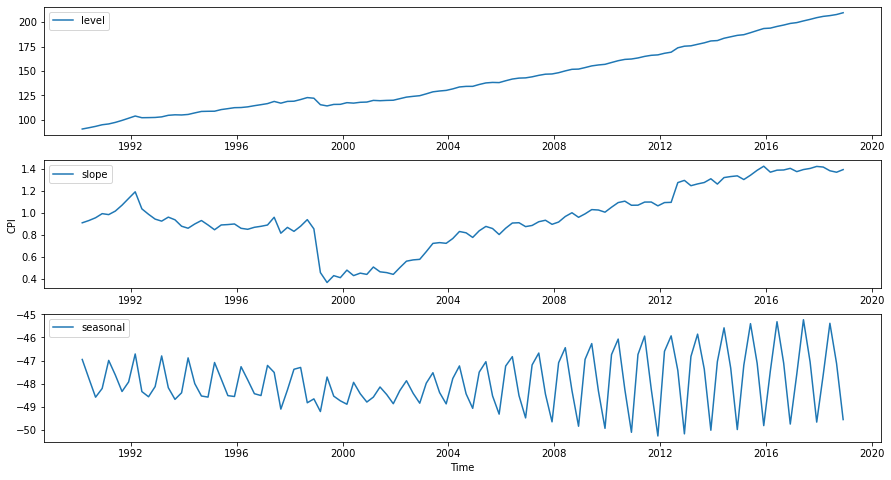

In [27]:
# Extract the fitted values of the training data
hw_fitted = hw.fittedvalues

# Plot the fitted results
fig, ax = plt.subplots(3, 1, figsize=(15,8))
ax[0].plot(train.index, hw.level)
ax[1].plot(train.index, hw.trend)
ax[2].plot(train.index, hw.season)
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.xlabel('Time')
ax[1].set_ylabel('CPI')
plt.show()

In [28]:
# Print the fitted results
print(hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      CPI   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                            222.116
Optimized:                         True   AIC                             91.354
Trend:                         Additive   BIC                            113.383
Seasonal:                      Additive   AICC                            93.450
Seasonal Periods:                     4   Date:                 Sun, 28 May 2023
Box-Cox:                          False   Time:                         16:51:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8046136                alpha                 True
smoothing_trend          

### 4.3.2 Forecast Result

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


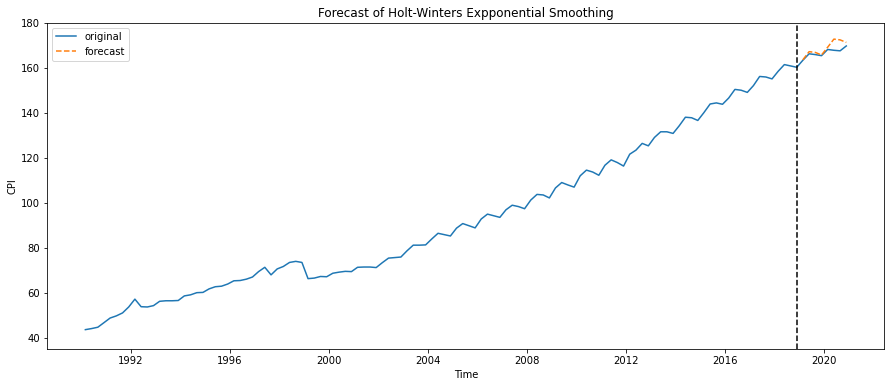

In [29]:
# Forecast the data after 2018
hw_forecast = hw.forecast(len(valid))

# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, hw_forecast, '--')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Holt-Winters Expponential Smoothing')
plt.legend(['original', 'forecast'], loc=2)
plt.ylim(35, 180)
plt.show()

In [30]:
# Calculate the MSE and MAPE of the forecast
hw_mse = MSE(valid, hw_forecast)
hw_mape = MAPE(valid, hw_forecast)
hw_aic = hw.aic

print("MSE of Holt-Winters exponential smoothing: {:.4f}".format(hw_mse))
print("MAPE of Holt-Winters exponential smoothing: {:.4f}%".format(hw_mape))
print("AIC of Holt-Winters exponential smoothing: {:.4f}".format(hw_aic))

MSE of Holt-Winters exponential smoothing: 6.7169
MAPE of Holt-Winters exponential smoothing: 1.1060%
AIC of Holt-Winters exponential smoothing: 91.3545


## 4.4 SARIMA process

Similarly, the SARIMA process is more suitable for the CPI data than the ARIMA process since it takes the effect of seasonality into consideration.

### 4.4.1 Model Construction

#### 1. Check stationarity

To apply a SARIMA model, we first check the stationairty of the data. This could help us to decide whether the CPI data needs differencing and choose the suitable orders for it.

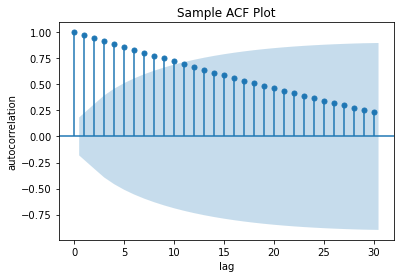

In [31]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(train, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

Since the sample ACF plot dies down slowly, plus there is an obvious trend component shown in the original data, it can be concluded that the data is not stationary. As a result, we need to determine the orders of differencing (for both non-seasonal and seasonal components) before fitting the data into a SARIMA model.

#### 2. Select the order of $d$ and $D$

For the non-seasonal component, since there is a visible trend in the orignal data, we can simply set $d$ = 1 according to the rules provided in the Tutorial 10. On the other hand, the seasonality aprrearing after 2000 also suggests that a seasonal differencing on the data is required. Conventionally, the value of $d + D$ is at most 2, so we decide to take the first order of non-seasonal differencing ($d = 1$) plus the first order of seasonal differencing ($D = 1$) on the orignal data and the one under the log scale and compare their stationarity using the sample ACF plot and Dickey-Fuller test.

(1) Without log transformation

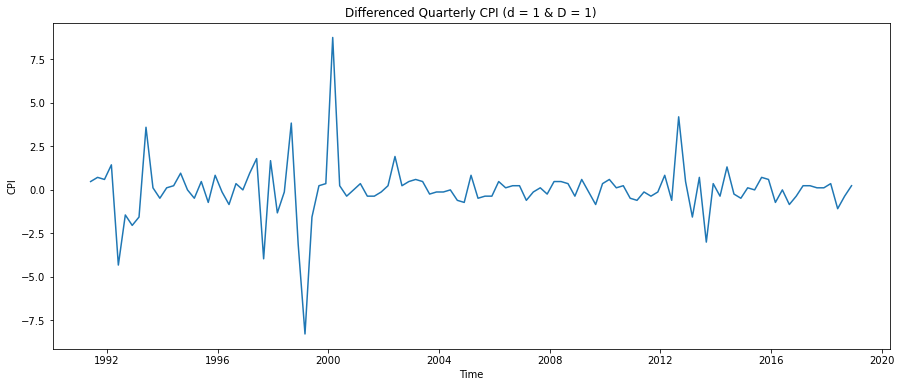

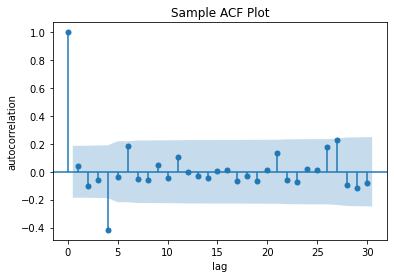

In [32]:
# Take the first order (non-seasonal) differencing
train_first_diff = train - train.shift()

# Take the first order seasonal differencing
train_second_diff = train_first_diff - train_first_diff.shift(4)
train_second_diff.dropna(inplace=True)

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(train_second_diff)
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Differenced Quarterly CPI (d = 1 & D = 1)')
plt.show()

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train_second_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

In [33]:
# Test the stationarity
dftest = adfuller(train_second_diff, autolag='AIC')  # perform a Dickey-Fuller test

# Extract the test results
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','Pvalue','Number of Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print('Results of Dickey-Fuller Test:')
print()
print(dfoutput)

Results of Dickey-Fuller Test:

Test Statistic                -6.083879e+00
Pvalue                         1.075947e-07
Number of Lags Used            7.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


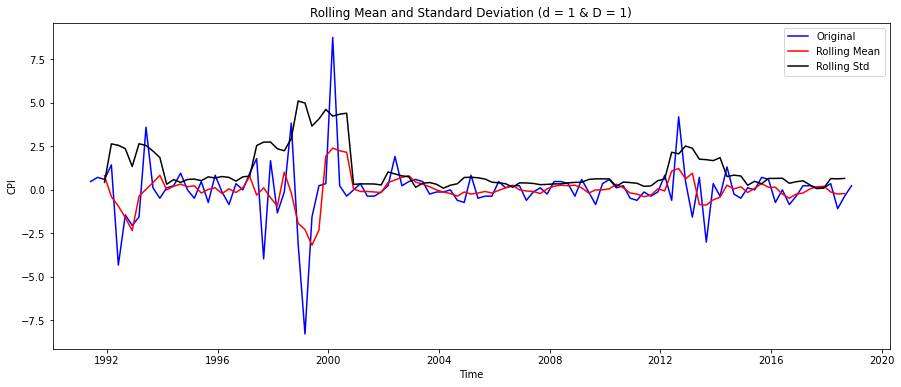

In [34]:
# Compute the rolling statistics
rolmean = train_second_diff.rolling(4, center=True).mean()
rolstd = train_second_diff.rolling(4, center=True).std()

# Plot the rolling statistics
plt.figure(figsize=(15,6))
plt.plot(train_second_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Rolling Mean and Standard Deviation (d = 1 & D = 1)')
plt.show()

(2) With log transformation

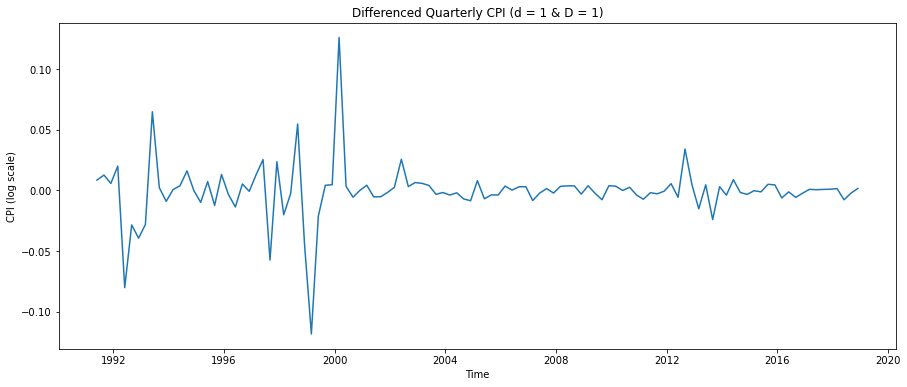

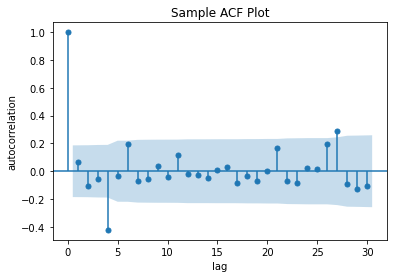

In [35]:
# Take the first order (non-seasonal) differencing
train_log_first_diff = np.log(train) - np.log(train).shift()

# Take the first order seasonal differencing
train_log_second_diff = train_log_first_diff - train_log_first_diff.shift(4)
train_log_second_diff.dropna(inplace=True)

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(train_log_second_diff)
plt.xlabel('Time')
plt.ylabel('CPI (log scale)')
plt.title('Differenced Quarterly CPI (d = 1 & D = 1)')
plt.show()

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train_log_second_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

In [36]:
# Test the stationarity
dftest = adfuller(train_log_second_diff, autolag='AIC')  # perform a Dickey-Fuller test

# Extract the test results
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','Pvalue','Number of Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print('Results of Dickey-Fuller Test:')
print()
print(dfoutput)

Results of Dickey-Fuller Test:

Test Statistic                -6.342965e+00
Pvalue                         2.726075e-08
Number of Lags Used            7.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


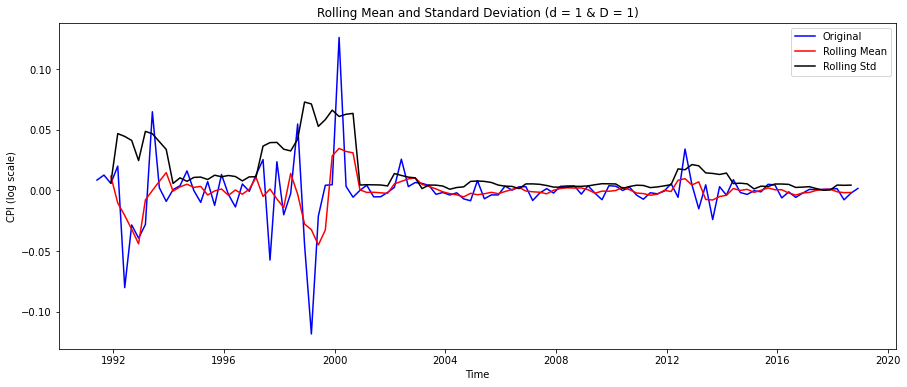

In [37]:
# Compute the rolling statistics
rolmean = train_log_second_diff.rolling(4, center=True).mean()
rolstd = train_log_second_diff.rolling(4, center=True).std()

# Plot the rolling statistics
plt.figure(figsize=(15,6))
plt.plot(train_log_second_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('CPI (log scale)')
plt.title('Rolling Mean and Standard Deviation (d = 1 & D = 1)')
plt.show()

Since the p-value of the Dickey-Fuller test under the log transofrmation is smaller than the one without the log transformation, we dicide to use the CPI data under the log scale to fit our SARIMA model.

Besides, it can be observed that no matter which case we use, both the sample ACF plots die down much quicker than before after we take the differencing, and the small p-values of the Dickey-Fuller test also show that the differenced data is stationary. Hence, we can stick to our choice of $d = 1$ and $D = 1$.

#### 3. Select the order of $(p, q)$ and $(P, Q)$

The next step is to choose the proper orders for both the $AR$ and $MA$ components, and we implement this by two ways. The first method is to follow the rules provided in the Tutorial 10 to deteremine all the orders by simply looking at the ACF and PACF plot. The other method is that we first decide the orders of $P$ and $Q$ by the ACF/PACF plot, and then use a grid search to select the best values of $p$ and $q$ based on the AIC. The final model is chosen based on the one with the smaller MSE/MAPE of the forecasts.

(1) Determine all the orders by looking at the ACF/PACF plot.

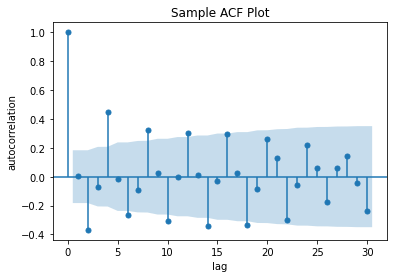

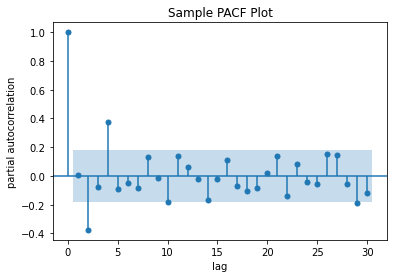

In [38]:
# Use the first differenced data to decide the order of P and Q
train_log_first_diff.dropna(inplace=True)  # remove the missing values

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train_log_first_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(train_log_first_diff, lags=30, alpha=0.05)
plt.title('Sample PACF Plot')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.show()

Since the PACF plot cuts off after that, this indicates $P = 1$ may be a proper choice for the CPI data. On the other hand, according to the rule of thumbs, $Q$ is non-zero only when the ACF at lag $m$, where $m$ equals to the seasonal frequency, is negative. However, in our case, the ACF at lag 4 is positive, and the values at the multiples of $m$ also die down relatively slowly. Hence, based on these observations, we decided to choose $Q = 0$ for this case.

As for the orders of $p$ and $q$, we use the lag value where the ACF/PACF first cuts off in the plot. This corresponds to lag = 0 in the both plots, so the order of $p$ and $q$ are both 0.

In [39]:
# Construct a SARIMA model with the selected parameters
sarima = SARIMAX(np.log(train), 
                 order=(0, 1, 0),
                 seasonal_order=(1, 1, 0, 4),
                 trend='c',
                 enforce_stationarity=False,
                 enforce_invertibility=False)

# Fit the model on the traning data
model = sarima.fit()

# Forecast the data after 2018
forecast = np.exp(model.forecast(len(valid)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


In [40]:
# Calculate the MSE and MAPE of the forecast
mse = mean_squared_error(valid, forecast)
mape = MAPE(valid, forecast)
aic = model.aic

print("MSE of SARIMA(0, 1, 0)(1, 1, 0) process: {:.4f}".format(mse))
print("MAPE of SARIMA(0, 1, 0)(1, 1, 0) process: {:.4f} %".format(mape))
print("AIC of SARIMA(0, 1, 0)(1, 1, 0) process: {:.4f}".format(aic))

MSE of SARIMA(0, 1, 0)(1, 1, 0) process: 2.5865
MAPE of SARIMA(0, 1, 0)(1, 1, 0) process: 0.5830 %
AIC of SARIMA(0, 1, 0)(1, 1, 0) process: -514.1484


(2) Determine the orders of $(P, Q)$ by the ACF/PACF plot and the ones of $(p, q)$ by grid search.

In [41]:
max_p = 3
max_q = 3
aics = pd.DataFrame(np.zeros((max_p+1, max_q+1)))

# Use grid search to decide the order of p and q
for p in range(max_p+1):
    for q in range(max_q+1):
        
        sarima = SARIMAX(np.log(train),                  # construct a SARIMA model 
                         order=(p, 1, q),
                         seasonal_order=(1, 1, 0, 4),
                         trend='c',
                         enforce_stationarity = False,
                         enforce_invertibility = False)
        model = sarima.fit()                             # fit the model on the training data       
        aics.iloc[p, q] = model.aic                      # extract the AIC value

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

In [42]:
# Extract the order of p and q with the minimum AIC
best_p = np.where(aics.values == aics.min().min())[0][0]
best_q = np.where(aics.values == aics.min().min())[1][0]

print("Best value of p with minimum AIC:", best_p)
print("Best value of q with minimum AIC:", best_q)

Best value of p with minimum AIC: 1
Best value of q with minimum AIC: 2


In [43]:
# Construct a SARIMA model with the selected parameters
sarima = SARIMAX(np.log(train), 
                 order=(1, 1, 2),
                 seasonal_order=(1, 1, 0, 4),
                 trend='c',
                 enforce_stationarity=False,
                 enforce_invertibility=False)

# Fit the model on the traning data
model = sarima.fit()

# Forecast the data after 2018
forecast = np.exp(model.forecast(len(valid)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
# Calculate the MSE and MAPE of the forecast
mse = mean_squared_error(valid, forecast)
mape = MAPE(valid, forecast)
aic = model.aic

print("MSE of SARIMA(1, 1, 2)(1, 1, 0) process: {:.4f}".format(mse))
print("MAPE of SARIMA(1, 1, 2)(1, 1, 0) process: {:.4f} %".format(mape))
print("AIC of SARIMA(1, 1, 2)(1, 1, 0) process: {:.4f}".format(aic))

MSE of SARIMA(1, 1, 2)(1, 1, 0) process: 9.4031
MAPE of SARIMA(1, 1, 2)(1, 1, 0) process: 1.4267 %
AIC of SARIMA(1, 1, 2)(1, 1, 0) process: -524.1122


Since the first model has a smaller MSE/MAPE, we use the parameters selected based on the first method as the final parameters of the SARIMA process.

#### 4. Costruct the model with the selected parameters

The final parameters of the SARIMA process are selected as follows:

- Non-seasonal components: $p = 0$, $d = 1$, $q = 0$
- Seasonal components: $P = 1$, $D = 1$, $Q = 0$

In [45]:
# Construct a SARIMA model with the final parameters
sarima = SARIMAX(np.log(train), 
                 order=(0, 1, 0),
                 seasonal_order=(1, 1, 0, 4),
                 trend='c',
                 enforce_stationarity=False,
                 enforce_invertibility=False)

# Fit the model on the traning data
model = sarima.fit()

# Extract the fitted values of the training data
sarima_fitted = np.exp(model.fittedvalues)

# Print out the fitted results
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               CPI   No. Observations:                  116
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 260.074
Date:                           Sun, 28 May 2023   AIC                           -514.148
Time:                                   16:52:01   BIC                           -506.130
Sample:                               03-01-1990   HQIC                          -510.898
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0015      0.002     -0.627      0.531      -0.006       0.003
ar.S.L4       -0.4228      0.036    -11.814

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


### 4.4.2 Forecast Result

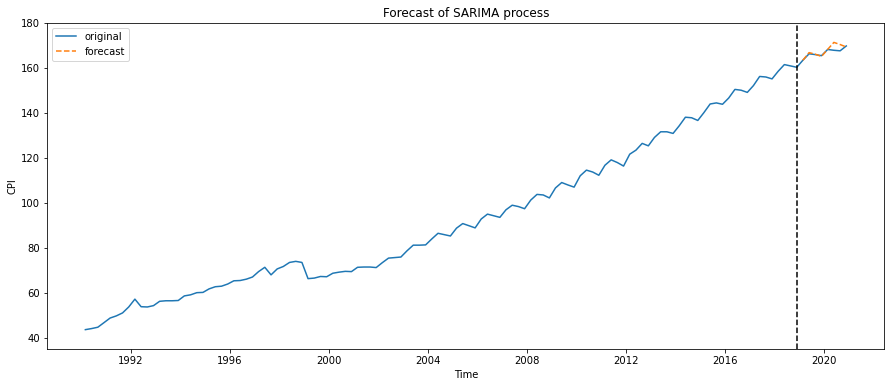

In [46]:
# Forecast the data after 2018
sarima_forecast = np.exp(model.forecast(len(valid)))

# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, sarima_forecast, '--')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of SARIMA process')
plt.legend(['original', 'forecast'], loc=2)
plt.ylim(35, 180)
plt.show()

In [47]:
# Calculate the MSE and MAPE of the forecast
sarima_mse = MSE(valid, sarima_forecast)
sarima_mape = MAPE(valid, sarima_forecast)
sarima_aic = model.aic

print("MSE of SARIMA(0, 1, 0)(1, 1, 0, 4) process: {:.4f}".format(sarima_mse))
print("MAPE of SARIMA(0, 1, 0)(1, 1, 0, 4) process: {:.4f}%".format(sarima_mape))
print("AIC of SARIMA(0, 1, 0)(1, 1, 0, 4) process: {:.4f}".format(sarima_aic))

MSE of SARIMA(0, 1, 0)(1, 1, 0, 4) process: 2.5865
MAPE of SARIMA(0, 1, 0)(1, 1, 0, 4) process: 0.5830%
AIC of SARIMA(0, 1, 0)(1, 1, 0, 4) process: -514.1484


## 4.5 Long Short-Term Memory (LSTM) Network

### 4.5.1 Model Construction

#### 1. Preprocessing

There are several preproccesing steps that are requird before we fit the data into of a LSTM model:

- Scale the data into [0, 1].
- Convert the data into 3D array.

In addtion, to find the best parameters, we use the last 4 data points in the training set to validate the model performance under different combinations of parameters in the tuning process. Note that we choose 4 as the size of the training-validation set because it is the minimum number of the data points required to evaluate the model's ability to capture the seasonality.

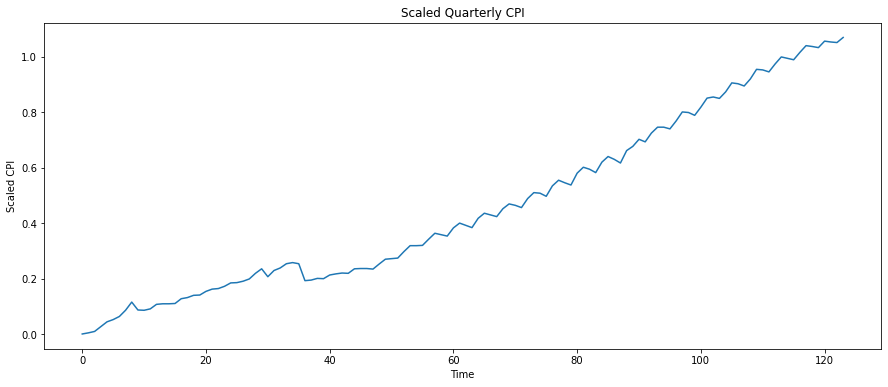

In [48]:
# Scale the data into [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))                           # construct a scaler
fitted_scaler = scaler.fit(np.array(train).reshape((-1, 1)))          # fit the training data
cpi_scaled = fitted_scaler.transform(np.array(cpi).reshape((-1, 1)))  # apply the scaler on th entire data

# Use the last 8 data points as the validation set
train_scaled = cpi_scaled[:-8]
valid_scaled = cpi_scaled[-8:]

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(cpi_scaled)
plt.xlabel('Time')
plt.ylabel('Scaled CPI')
plt.title('Scaled Quarterly CPI')
plt.show()

In [49]:
# Use the last 4 data points in the training set as the training-validation set for hyperparameter tuning
train_train_scaled = train_scaled[:-4]
train_valid = train[-4:]
print('Number of data points in the training-training set:', train_train_scaled.shape[0])
print('Number of data points in the training-validation set:', train_valid.shape[0])

Number of data points in the training-training set: 112
Number of data points in the training-validation set: 4


In [50]:
# Define the input and target data (training-training set)
time_window = 4
X_train_train_lstm = np.zeros((len(train_train_scaled)-time_window, time_window))
y_train_train_lstm = np.zeros((len(train_train_scaled)-time_window, 1))

for i in range(time_window, len(train_train_scaled)):
    X_train_train_lstm[i-time_window] = train_train_scaled[i-time_window:i].flatten()
    y_train_train_lstm[i-time_window] = train_train_scaled[i]
    
# Reshape the input data into 3D array
X_train_train_lstm = X_train_train_lstm.reshape((X_train_train_lstm.shape[0], time_window, 1))
    
print('Shape of the input training-training data:', X_train_train_lstm.shape)
print('Shape of the target training-training data:', y_train_train_lstm.shape)

Shape of the input training-training data: (108, 4, 1)
Shape of the target training-training data: (108, 1)


#### 2. Hyperparameter tuning

(1) Determine the number of epochs

In order to limit the number of parameters to tune, we first determine the number of epochs required for the model to reach a stable performance by fitting a LSTM model using the largest batch size (which is 40) we would like to test. A suitable number of epochs should be around the point where the decrease of the training loss starts to slow down according to the elbow method.

In [51]:
# Construct a LSTM model
lstm = Sequential()
lstm.add(LSTM(8, input_shape=(time_window, 1))) 
lstm.add(Dense(1))

# Define the loss function and optimizer
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Print the summary of the model
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Fit the model on the training data
model = lstm.fit(X_train_train_lstm, y_train_train_lstm, 
                 batch_size=40,             
                 epochs=300,
                 shuffle=False,
                 verbose=1)

Epoch 1/300
3/3 [==============================] - 1s 2ms/step - loss: 0.5755
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 0.5500
Epoch 3/300
3/3 [==============================] - 0s 2ms/step - loss: 0.5258
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 0.5025
Epoch 5/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4801
Epoch 6/300
3/3 [==============================] - 0s 2ms/step - loss: 0.4588
Epoch 7/300
3/3 [==============================] - 0s 2ms/step - loss: 0.4383
Epoch 8/300
3/3 [==============================] - 0s 2ms/step - loss: 0.4188
Epoch 9/300
3/3 [==============================] - 0s 2ms/step - loss: 0.4002
Epoch 10/300
3/3 [==============================] - 0s 2ms/step - loss: 0.3825
Epoch 11/300
3/3 [==============================] - 0s 2ms/step - loss: 0.3655
Epoch 12/300
3/3 [==============================] - 0s 2ms/step - loss: 0.3494
Epoch 13/300
3/3 [==============================] - 0s 2ms/st

3/3 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 207/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 208/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 209/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 210/300
3/3 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 211/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 212/300
3/3 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 213/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 214/300
3/3 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 215/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 216/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 217/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 218/300
3/3 [==============================] - 0

Text(0, 0.5, 'loss')

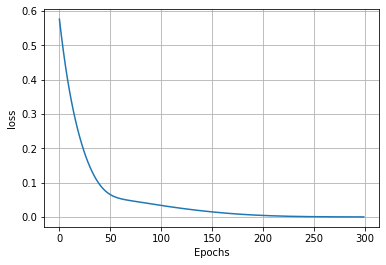

In [53]:
loss = model.history['loss']

plt.figure(figsize=(6, 4))
plt.plot(loss)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('loss')

Since the training loss does not change much after 200 epochs, we can use 200 epochs as a fixed parameter of the model.

(2) Determine the size of time window, number of hidden neurons, and batach size.

The next step is to use grid search to determine the rest of the parameters in the model. The parameters we choose to tune and their tuning values are summarized as follows:

- **time window:** 4, 8
- **number of hidden neurons:** 4, 8, 16, 32
- **batach size:** 5, 10, 20, 40

Note that we do not include many possibilities for the size of the time window as a large window size may compress the data size available for model training.

In [54]:
def lstm_forecast_mse(time_window, n_hidden_neurons, batch_size):
    
    # Define the input and target data (training-training set)
    X_train_train_lstm = np.zeros((len(train_train_scaled)-time_window, time_window))
    y_train_train_lstm = np.zeros((len(train_train_scaled)-time_window, 1))

    for i in range(time_window, len(train_train_scaled)):
        X_train_train_lstm[i-time_window] = train_train_scaled[i-time_window:i].flatten()
        y_train_train_lstm[i-time_window] = train_train_scaled[i]

    # Reshape the input data into 3D array
    X_train_train_lstm = X_train_train_lstm.reshape((X_train_train_lstm.shape[0], time_window, 1))
    
    # Construct a LSTM model
    lstm = Sequential()
    lstm.add(LSTM(n_hidden_neurons, input_shape=(time_window, 1), activation='relu'))
    lstm.add(Dense(1))

    # Define the loss function and optimizer
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fit the model on the training data
    model = lstm.fit(X_train_train_lstm, y_train_train_lstm, 
                     batch_size=batch_size,             
                     epochs=200, 
                     shuffle=False,
                     verbose=0)
    
    # Define the input data (training-validation set)
    dynamic_pred = train_train_scaled[-time_window:]
    forecasts = np.zeros((len(train_valid), 1))

    # Forecast the data
    for i in range(len(train_valid)):
        X_train_valid_lstm = dynamic_pred[-time_window:].reshape((1, time_window, 1))
        forecast = lstm.predict(X_train_valid_lstm)
        forecasts[i] = forecast[0]
        dynamic_pred = np.append(dynamic_pred, forecast)

    # Transform the forecast back into the original scale
    forecasts = scaler.inverse_transform(forecasts)
    
    # Calculate the MSE and MAPE of the forecast
    mse = mean_squared_error(train_valid, forecasts)
    
    return mse

In [55]:
time_window = [4, 8]
n_hidden_neurons = [4, 8, 16, 32]
batch_size = [5, 10, 20, 40]
params = []
mses = []

# Gird search
for window_size in time_window:
    for neuron in n_hidden_neurons:
        for batch in batch_size:
            print(f'parameters: time_window = {window_size}, n_hidden_neurons = {neuron}, batch_size = {batch}')
            mse = lstm_forecast_mse(window_size, neuron, batch)
            mses.append(mse)
            params.append(f'time_window = {window_size}, n_hidden_neurons = {neuron}, batch_size = {batch}')

parameters: time_window = 4, n_hidden_neurons = 4, batch_size = 5
1/1 [==============================] - 0s 15ms/step
parameters: time_window = 4, n_hidden_neurons = 4, batch_size = 10
1/1 [==============================] - 0s 16ms/step
parameters: time_window = 4, n_hidden_neurons = 4, batch_size = 20
1/1 [==============================] - 0s 14ms/step
parameters: time_window = 4, n_hidden_neurons = 4, batch_size = 40
1/1 [==============================] - 0s 18ms/step
parameters: time_window = 4, n_hidden_neurons = 8, batch_size = 5
1/1 [==============================] - 0s 16ms/step
parameters: time_window = 4, n_hidden_neurons = 8, batch_size = 10
1/1 [==============================] - 0s 14ms/step
parameters: time_window = 4, n_hidden_neurons = 8, batch_size = 20
1/1 [==============================] - 0s 17ms/step
parameters: time_window = 4, n_hidden_neurons = 8, batch_size = 40
1/1 [==============================] - 0s 16ms/step
parameters: time_window = 4, n_hidden_neurons = 16

In [56]:
# Extract the parameters with the lowest MSE
print('Best parameters with lowest MSE:', params[np.argmin(mses)])

Best parameters with lowest MSE: time_window = 4, n_hidden_neurons = 32, batch_size = 20


#### 3. Construct the final model with the selected parameters

After the parameters are decided, we make the forecast by retraining a LSTM model based on the entire training set. Since the forecast results generated by the LSTM are rletively diverging, we use the average of the 10 different forecasts as the final result of the LSTM.

In [57]:
# Define the input and target data (training set)
time_window = 4
X_train_lstm = np.zeros((len(train_scaled)-time_window, time_window))
y_train_lstm = np.zeros((len(train_scaled)-time_window, 1))

for i in range(time_window, len(train_scaled)):
    X_train_lstm[i-time_window] = train_scaled[i-time_window:i].flatten()
    y_train_lstm[i-time_window] = train_scaled[i]
    
# Reshape the input data into 3D array
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], time_window, 1))
    
print('Shape of the input training data:', X_train_lstm.shape)
print('Shape of the target training data:', y_train_lstm.shape)

Shape of the input training data: (112, 4, 1)
Shape of the target training data: (112, 1)


In [58]:
# Construct a LSTM model with the final parameters
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(time_window, 1))) 
lstm.add(Dense(1))

# Define the loss function and optimizer
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Fit the training data
lstm.fit(X_train_lstm, y_train_lstm, 
         batch_size=10,             
         epochs=200,
         shuffle=False,
         verbose=0)

# Compute the fitted values
lstm_fitted = lstm.predict(X_train_lstm, verbose=0)
lstm_fitted = scaler.inverse_transform(lstm_fitted) # transform the fitted values back into the original scale

### 4.5.2 Forecast Result

In [59]:
# Define the input data (validation set)
dynamic_pred = train_scaled[-time_window:]
lstm_forecast = np.zeros((len(valid), 1))

# Forecast the data after 2018
for i in range(len(valid)):
    X_valid_lstm = dynamic_pred[-time_window:].reshape((1, time_window, 1))
    forecast = lstm.predict(X_valid_lstm)
    lstm_forecast[i] = forecast[0]
    dynamic_pred = np.append(dynamic_pred, forecast)

# Transform the forecast back into the original scale
lstm_forecast = scaler.inverse_transform(lstm_forecast)

1/1 [==============================] - 0s 15ms/step


In [60]:
# Calculate the MSE and MAPE of the forecast
lstm_mse = MSE(valid, lstm_forecast.flatten())
lstm_mape = MAPE(valid, lstm_forecast.flatten())

print("MSE of long short-term memory network: {:.4f}".format(lstm_mse))
print("MAPE of long short-term memory network: {:.4f}%".format(lstm_mape))

MSE of long short-term memory network: 1.7073
MAPE of long short-term memory network: 0.6420%


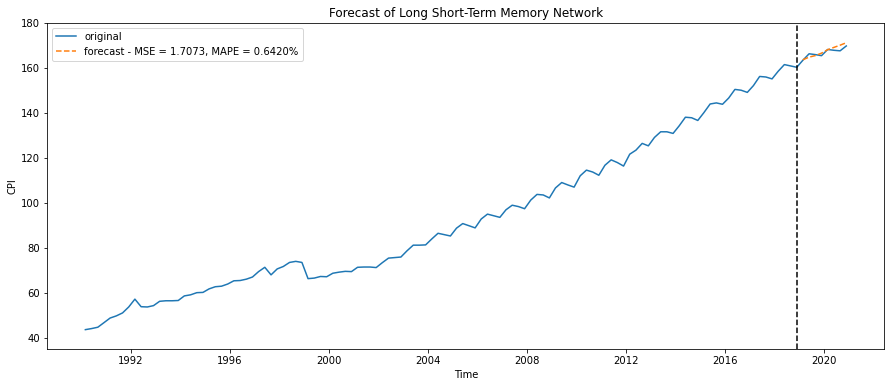

In [61]:
# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, lstm_forecast, '--')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Long Short-Term Memory Network')
plt.legend(['original', 'forecast - MSE = {:.4f}, MAPE = {:.4f}%'.format(lstm_mse, lstm_mape)], loc=2)
plt.ylim(35, 180)
plt.show()

# 5. Forecasting without data before 2000

As suggested previously, we also investigate the forecasting ability of different methods by using only the data after 2000 as there is a clear change in the pattern after that.

Again, we use the last 8 data points of the new data as the validation set to compare the performance of different forecast methods.

In [62]:
# Remove the data before 2000
cpi00 = cpi[40:]

# Use last 8 points of data as validation set
train00 = cpi00[:-8]  # note that the validation set is unchanged
                      # so we only need to create a new variable to specify the new training set

print('Number of data points in the training set:', len(train00))
print('Number of data points in the validation set:', len(valid))

Number of data points in the training set: 76
Number of data points in the validation set: 8


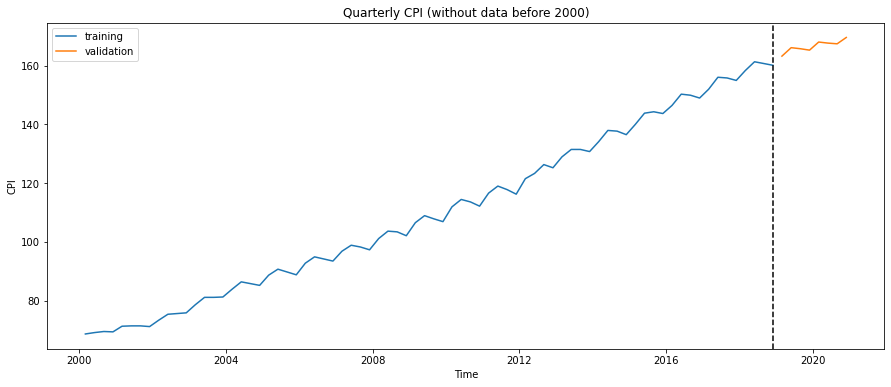

In [63]:
# Plot the training and validation data
plt.figure(figsize=(15,6))
plt.plot(train00)
plt.plot(valid)
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Quarterly CPI (without data before 2000)')
plt.legend(['training', 'validation'], loc=2)
plt.show()

## 5.1 Time Seires Decomposition

### 5.1.1 Model Implementation

In [64]:
# Estimate the trend component using CMA-4
trend_est = train00.rolling(4, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Estimate the seasonal component
detrended = train00 - trend_est                        # compute detrended data
detrended_zero = np.nan_to_num(detrended)              # replace missing values by zeros
detrended_zero = detrended_zero.reshape((-1, 4))
quaterly_avg = np.mean(detrended_zero[1:28], axis=0)   # calculate quaterly average (exclude first and last year)
seasonal_idx = quaterly_avg - quaterly_avg.mean()      # normalize seasonal indices
seasonal_est = np.tile(seasonal_idx, len(train00)//4)  # replicate seasonal indices

In [65]:
# Re-estimate the trend component by modeling
seasonal_adjusted = train00 - seasonal_est  # compute the seasonally adjusted data

train_time = np.arange(1, len(train00)+1)    
X_train_tsd = train_time.reshape((-1, 1))  # define the input data of the training set
y_train_tsd = seasonal_adjusted            # define the target data of the training set

lr00 = OLS(y_train_tsd, add_constant(X_train_tsd)).fit()  # fit a linear regression model
trend_model = lr00.predict(add_constant(X_train_tsd))     # compute the fitted trend component
tsd_fitted = trend_model + seasonal_est                   # compute the fitted values of the training data

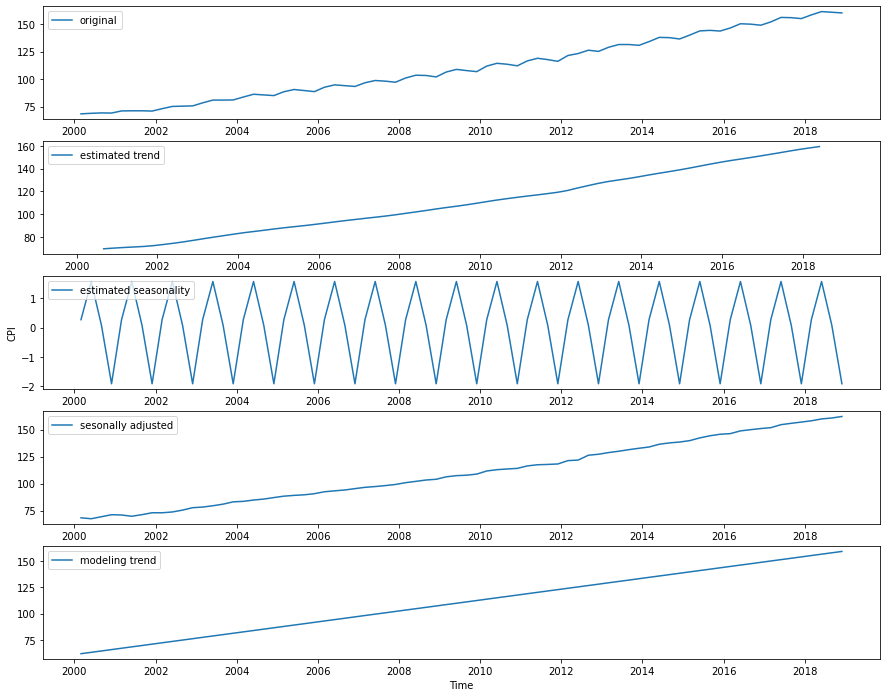

In [66]:
# Plot the fitted results
fig, ax = plt.subplots(5, 1, figsize=(15,12))
ax[0].plot(train00.index, train00)
ax[1].plot(train00.index, trend_est)
ax[2].plot(train00.index, seasonal_est)
ax[3].plot(train00.index, seasonal_adjusted)
ax[4].plot(train00.index, trend_model)
ax[0].legend(['original'], loc=2)
ax[1].legend(['estimated trend'], loc=2)
ax[2].legend(['estimated seasonality'], loc=2)
ax[3].legend(['sesonally adjusted'], loc=2)
ax[4].legend(['modeling trend'], loc=2)
plt.xlabel('Time')
ax[2].set_ylabel('CPI')
ax[1].set_xlim(datetime.strptime('1999-03-01', '%Y-%m-%d'), datetime.strptime('2019-12-01', '%Y-%m-%d'))
plt.show()

### 5.1.2 Forecast Result

In [67]:
# Forecast the data after 2018
valid_time = np.arange(len(train00)+1, len(train00)+9)
X_valid_tsd = valid_time.reshape(-1, 1)                   # define the input data of the validation set
trend_forecast = lr00.predict(add_constant(X_valid_tsd))  # forecast the trend component
seasonal_forecast = np.tile(seasonal_idx, 2)              # forecast the seasonal component
tsd00_forecast = trend_forecast + seasonal_forecast       # add the forcasted trend and seasonal component

In [68]:
# Calculate the MSE and MAPE of the forecast
tsd00_mse = MSE(valid, pd.Series(tsd00_forecast).set_axis(valid.index))
tsd00_mape = MAPE(valid, pd.Series(tsd00_forecast).set_axis(valid.index))
tsd00_aic = lr00.aic

print("MSE of time series decomposition (with data before 2000): {:.4f}".format(tsd00_mse))
print("MAPE of time series decomposition (with data before 2000): {:.4f}%".format(tsd00_mape))
print('AIC of time series decompostion (with data before 2000): {:.4f}'.format(tsd00_aic))

MSE of time series decomposition (with data before 2000): 5.8647
MAPE of time series decomposition (with data before 2000): 1.3290%
AIC of time series decompostion (with data before 2000): 354.3213


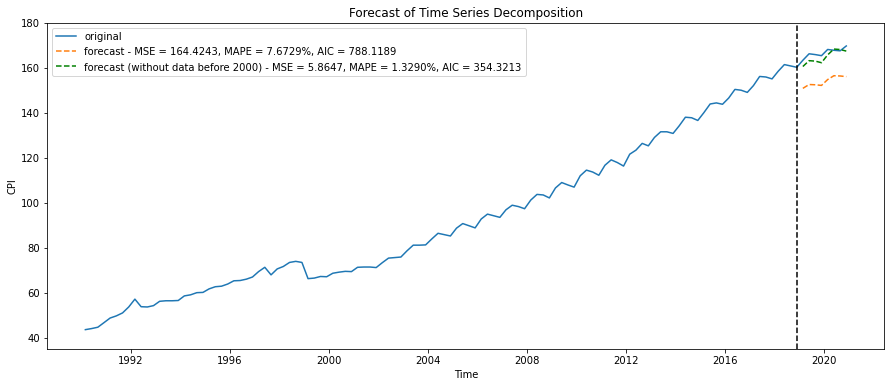

In [69]:
# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, tsd_forecast, '--')
plt.plot(valid.index, tsd00_forecast, '--g')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Time Series Decomposition')
plt.legend(['original', 'forecast - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(tsd_mse, tsd_mape, tsd_aic),
            'forecast (without data before 2000) - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(tsd00_mse, tsd00_mape, tsd00_aic)], loc=2)
plt.ylim(35, 180)
plt.show()

### 5.1.3 Residual Diagnostics

**1. Residual plot against predictors/fitted values**: check whether the data follows a linear relationship/ the residuals follow homoscedasticity.

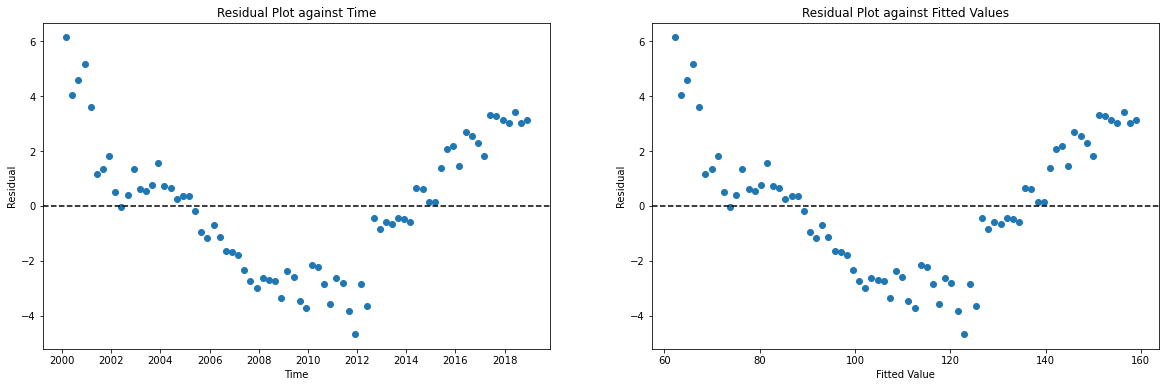

In [70]:
# Compute the residuals
tsd00_res = seasonal_adjusted - trend_model

# Plot the residuals against the time variable and fitted values
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].scatter(train00.index, tsd00_res)
ax[1].scatter(trend_model, tsd00_res)
ax[0].axhline(y=0, color='black', ls='--')
ax[1].axhline(y=0, color='black', ls='--')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Fitted Value')
ax[0].set_ylabel('Residual')
ax[1].set_ylabel('Residual')
ax[0].set_title('Residual Plot against Time')
ax[1].set_title('Residual Plot against Fitted Values')
plt.show()

**2. ACF/PACF plot:** check the autocorrelation in the residuals.

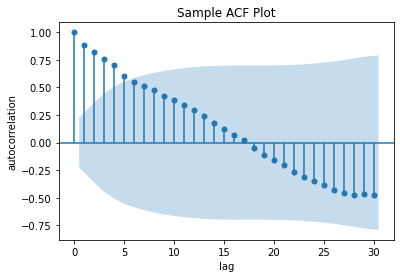

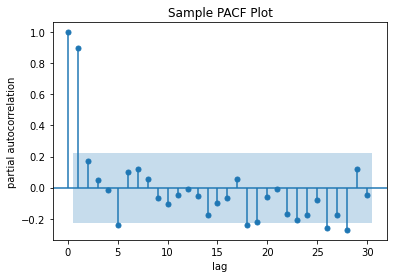

In [71]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(tsd00_res, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(tsd00_res, lags=30, alpha=0.05)
plt.title('Sample PACF Plot')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.show()

**3. Histogram of residuals:** check whether the residuals are normally distributed.

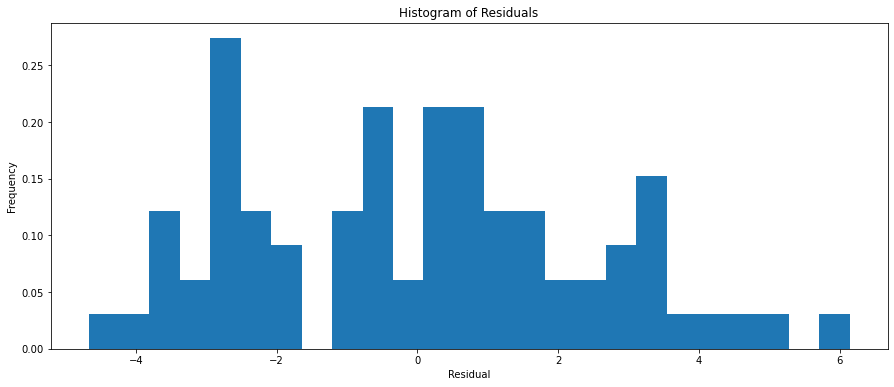

In [72]:
# Plot the histogram of the residuals
plt.figure(figsize=(15,6))
plt.hist(tsd00_res, bins=25, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The results show that even we discard the dara before 2000, the linear regression model is still not a suitable choice to model the seasonally adjusted CPI data. The autocorelation in the residuals is slightly lower than the one using the entire data. However, there are still patterns shown in the residual plots, and the assumption of the normal distriubtion is obviously not satisfied as well. 

## 5.2 Linear Regression

### 5.2.1 Model Construction

In [73]:
# Create seasonal dummy variables
seasons = []
for i in range(len(cpi00)):
    if i % 4 == 0:
        seasons = np.append(seasons, 'Q1')
    if i % 4 == 1:
        seasons = np.append(seasons, 'Q2')
    if i % 4 == 2:
        seasons = np.append(seasons, 'Q3')
    if i % 4 == 3:
        seasons = np.append(seasons, 'Q4')
        
seasonal_dummy = pd.get_dummies(seasons, drop_first=True)
seasonal_dummy.head()

,Q2,Q3,Q4
0,0,0,0
1,1,0,0
2,0,1,0
3,0,0,1
4,0,0,0


In [74]:
# Define the input and target data of the traning set
X_train_lr = np.hstack((seasonal_dummy[:len(train00)], train_time.reshape(-1, 1)))  # add the time variable
y_train_lr = train00

# Fit a linear regression model
lr00 = OLS(y_train_lr, add_constant(X_train_lr)).fit()

# Print the fitted results
print(lr00.summary())

# Compute the fitted values of the training data
lr00_fitted = lr00.predict(add_constant(X_train_lr))

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2417.
Date:                Sun, 28 May 2023   Prob (F-statistic):           4.88e-75
Time:                        16:54:20   Log-Likelihood:                -175.13
No. Observations:                  76   AIC:                             360.3
Df Residuals:                      71   BIC:                             371.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.2700      0.753     81.364      0.0

### 5.2.3 Forecast Result

In [75]:
# Forecast the data after 2018
X_valid_lr = np.hstack((seasonal_dummy[len(train00):], valid_time.reshape(-1, 1)))  # define the input data of the validation set
lr00_forecast = lr00.predict(add_constant(X_valid_lr))

In [76]:
# Calculate the MSE and MAPE of the forecast
lr00_mse = MSE(valid, pd.Series(lr00_forecast).set_axis(valid.index))
lr00_mape = MAPE(valid, pd.Series(lr00_forecast).set_axis(valid.index))
lr00_aic = lr00.aic

print("MSE of linear regression (without data before 2000): {:.4f}".format(lr00_mse))
print("MAPE of linear regression (without data before 2000): {:.4f}%".format(lr00_mape))
print('AIC of linear regression (with data before 2000): {:.4f}'.format(lr00_aic))

MSE of linear regression (without data before 2000): 5.8248
MAPE of linear regression (without data before 2000): 1.3214%
AIC of linear regression (with data before 2000): 360.2621


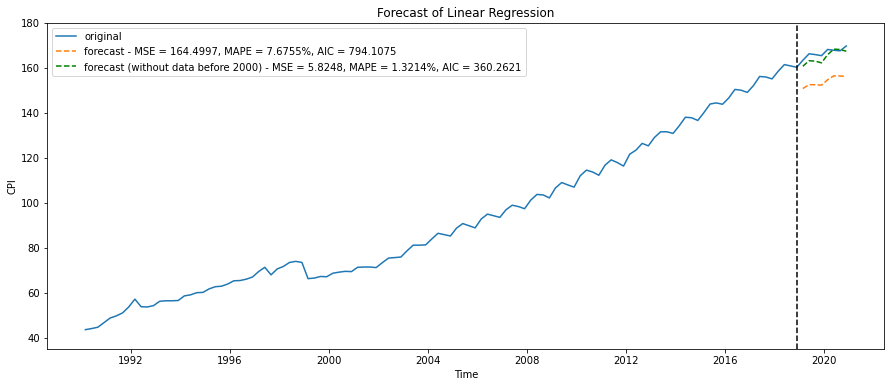

In [77]:
# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, lr_forecast, '--')
plt.plot(valid.index, lr00_forecast, '--g')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Linear Regression')
plt.legend(['original', 'forecast - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(lr_mse, lr_mape, lr_aic),
            'forecast (without data before 2000) - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(lr00_mse, lr00_mape, lr00_aic)], loc=2)
plt.ylim(35, 180)
plt.show()

### 5.2.3 Residual Diagnostics

**1. Residual plot against predictors/fitted values**: check whether the data follows a linear relationship/ the residuals follow homoscedasticity.

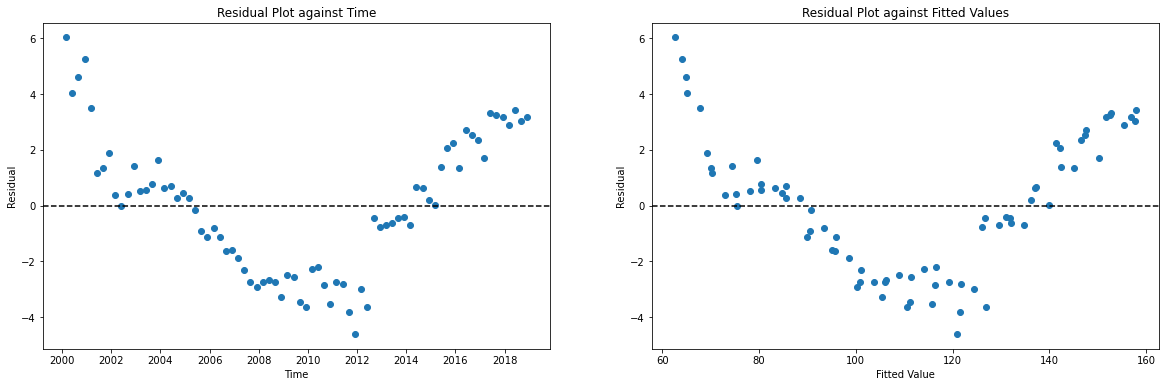

In [78]:
# Compute the residuals
lr00_res = train00 - lr00_fitted

# Plot the residuals against the time variable and fitted values
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].scatter(train00.index, lr00_res)
ax[1].scatter(lr00_fitted, lr00_res)
ax[0].axhline(y=0, color='black', ls='--')
ax[1].axhline(y=0, color='black', ls='--')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Fitted Value')
ax[0].set_ylabel('Residual')
ax[1].set_ylabel('Residual')
ax[0].set_title('Residual Plot against Time')
ax[1].set_title('Residual Plot against Fitted Values')
plt.show()

**2. ACF/PACF plot:** check the autocorrelation in the residuals.

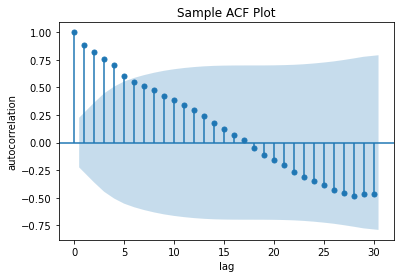

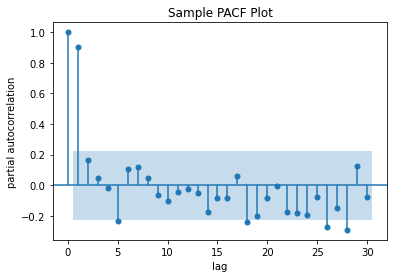

In [79]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(lr00_res, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(lr00_res, lags=30, alpha=0.05)
plt.title('Sample PACF Plot')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.show()

**3. Histogram of residuals:** check whether the residuals are normally distributed.

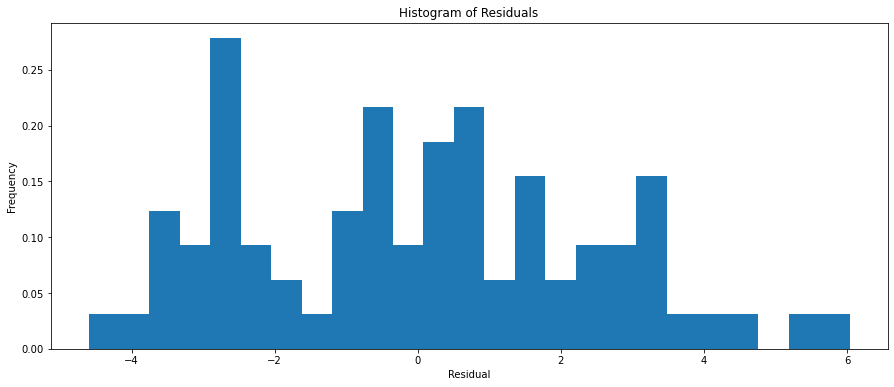

In [80]:
# Check the distribution of the residuals
plt.figure(figsize=(15,6))
plt.hist(lr00_res, bins=25, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Similar to the reuslts obtained using the entire data, the residual diagonstics without the data before 2000 suggests the linear regression is not a suitable choice for modeling and making forecast of the CPI data. Even though the autocorrelation in the residuals is smaller compared to the original model, and their distribution is closer to the normal distribution as well, theare are still strong patterns shown in the both residual plots.

## 5.3 Holt-Winters Exponential Smoothing

### 5.3.1 Model Construction

In [81]:
# Fit a Holt-Winters exopnential smoothing model
hw00 = ExponentialSmoothing(train00, seasonal_periods=4, trend='add', seasonal='add').fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


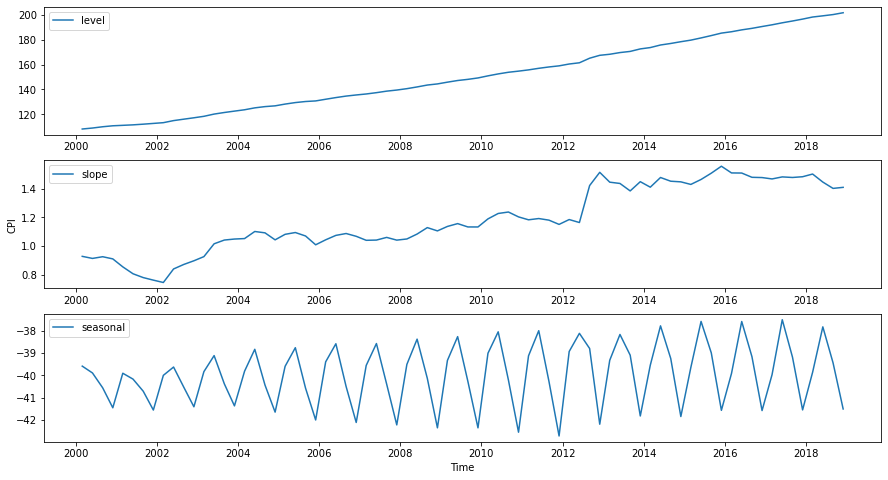

In [82]:
# Extract the fitted values of the training data
hw00_fitted = hw00.fittedvalues

# Plot the fitted results
fig, ax = plt.subplots(3, 1, figsize=(15,8))
ax[0].plot(train00.index, hw00.level)
ax[1].plot(train00.index, hw00.trend)
ax[2].plot(train00.index, hw00.season)
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.xlabel('Time')
ax[1].set_ylabel('CPI')
plt.show()

In [83]:
# Print the fitted results
print(hw00.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      CPI   No. Observations:                   76
Model:             ExponentialSmoothing   SSE                             39.744
Optimized:                         True   AIC                            -33.270
Trend:                         Additive   BIC                            -14.624
Seasonal:                      Additive   AICC                           -29.885
Seasonal Periods:                     4   Date:                 Sun, 28 May 2023
Box-Cox:                          False   Time:                         16:54:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6294652                alpha                 True
smoothing_trend          

### 5.3.2 Forecast Result

In [84]:
# Forecast the data after 2018
hw00_forecast = hw00.forecast(len(valid))

# Calculate the MSE and MAPE of the forecast
hw00_mse = MSE(valid, hw00_forecast)
hw00_mape = MAPE(valid, hw00_forecast)
hw00_aic = hw00.aic

print("MSE of Holt-Winters exponential smoothing (without data before 2000): {:.4f}".format(hw00_mse))
print("MAPE of Holt-Winters exponential smoothing (without data before 2000): {:.4f}%".format(hw00_mape))
print("AIC of Holt-Winters exponential smoothing (without data before 2000): {:.4f}".format(hw00_aic))

MSE of Holt-Winters exponential smoothing (without data before 2000): 5.9030
MAPE of Holt-Winters exponential smoothing (without data before 2000): 1.0037%
AIC of Holt-Winters exponential smoothing (without data before 2000): -33.2696


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


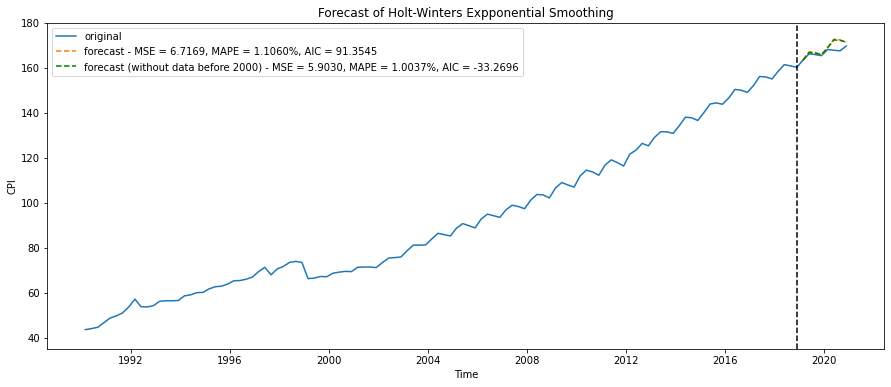

In [85]:
# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, hw_forecast, '--')
plt.plot(valid.index, hw00_forecast, '--g')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of Holt-Winters Expponential Smoothing')
plt.legend(['original', 'forecast - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(hw_mse, hw_mape, hw_aic),
            'forecast (without data before 2000) - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(hw00_mse, hw00_mape, hw00_aic)], loc=2)
plt.ylim(35, 180)
plt.show()

## 5.4 SARIMA process

### 5.4.1 Model Construction

#### 1. Check stationarity

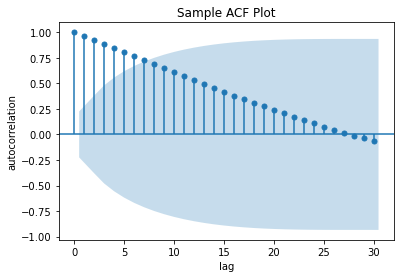

In [86]:
# Plot the ACF plot
smt.graphics.tsa.plot_acf(train00, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

Similar to the original data, the ACF plot of the CPI data after 2000 still dies down relatively slow. Hence, differencing is still required before we apply a SARIMA model on it.

#### 2. Select the order $d$ and $D$

Again, we choose $d = 1$ and $D = 1$ as both the trend and the seasonal components are still visible in the CPI data after 2000.

(1) Without log transformation

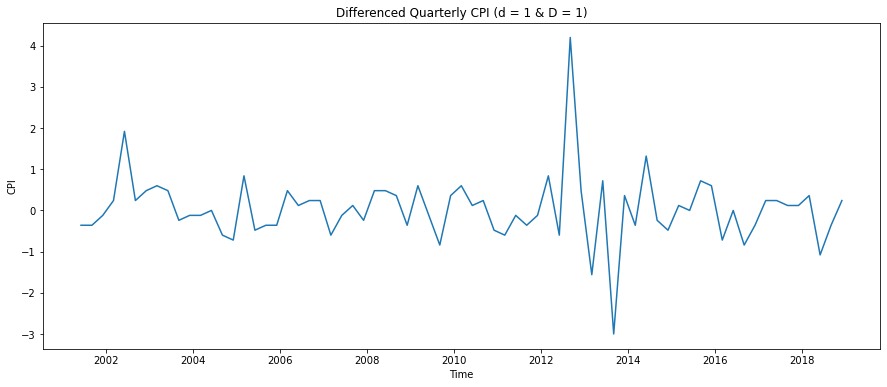

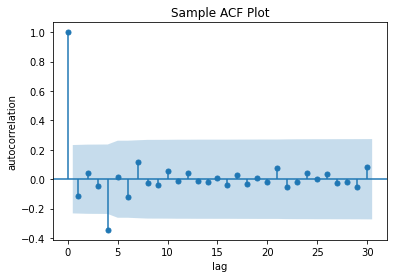

In [87]:
# Take the first order (non-seasonal) differencing
train00_first_diff = train00 - train00.shift()

# Take the first order seasonal differencing
train00_second_diff = train00_first_diff - train00_first_diff.shift(4)
train00_second_diff.dropna(inplace=True)

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(train00_second_diff)
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Differenced Quarterly CPI (d = 1 & D = 1)')
plt.show()

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train00_second_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

In [88]:
# Test the stationarity
dftest = adfuller(train00_second_diff, autolag='AIC')  # perform a Dickey-Fuller test

# Extract the test results
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','Pvalue','Number of Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print('Results of Dickey-Fuller Test:')
print()
print(dfoutput)

Results of Dickey-Fuller Test:

Test Statistic                -5.999564e+00
Pvalue                         1.669898e-07
Number of Lags Used            3.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


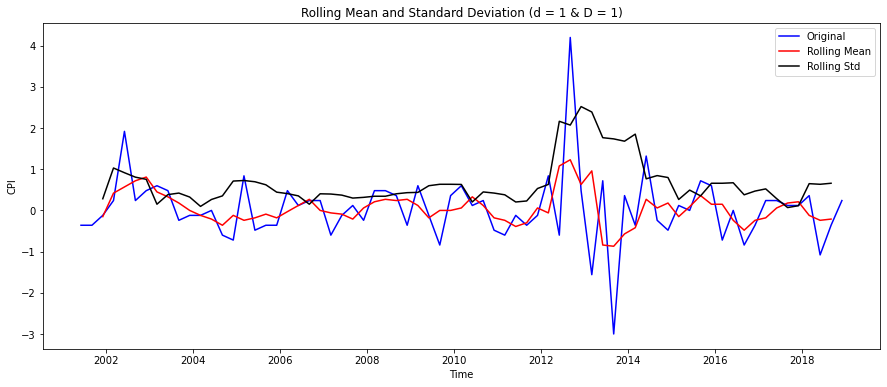

In [89]:
# Compute the rolling statistics
rolmean = train00_second_diff.rolling(4, center=True).mean()
rolstd = train00_second_diff.rolling(4, center=True).std()

# Plot the rolling statistics
plt.figure(figsize=(15,6))
plt.plot(train00_second_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Rolling Mean and Standard Deviation (d = 1 & D = 1)')
plt.show()

(2) With log transformation

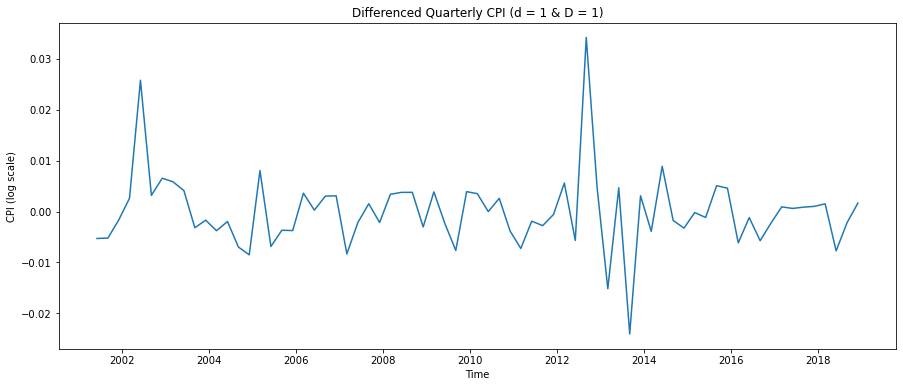

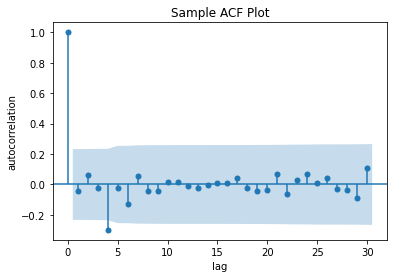

In [90]:
# Take the first order (non-seasonal) differencing
train00_log_first_diff = np.log(train00) - np.log(train00).shift()

# Take the first order seasonal differencing
train00_log_second_diff = train00_log_first_diff - train00_log_first_diff.shift(4)
train00_log_second_diff.dropna(inplace=True)

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(train00_log_second_diff)
plt.xlabel('Time')
plt.ylabel('CPI (log scale)')
plt.title('Differenced Quarterly CPI (d = 1 & D = 1)')
plt.show()

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train00_log_second_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

In [91]:
# Test the stationarity
dftest = adfuller(train00_log_second_diff, autolag='AIC')  # perform a Dickey-Fuller test

# Extract the test results
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','Pvalue','Number of Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print('Results of Dickey-Fuller Test:')
print()
print(dfoutput)

Results of Dickey-Fuller Test:

Test Statistic                 -5.384230
Pvalue                          0.000004
Number of Lags Used             3.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


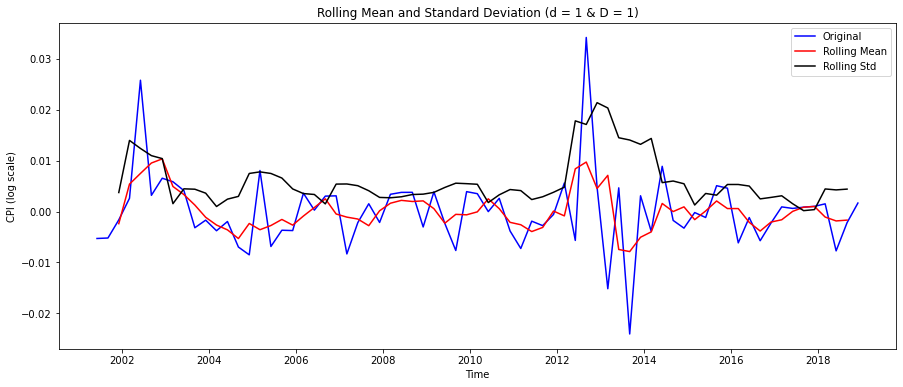

In [92]:
# Compute the rolling statistics
rolmean = train00_log_second_diff.rolling(4, center=True).mean()
rolstd = train00_log_second_diff.rolling(4, center=True).std()

# Plot the rolling statistics
plt.figure(figsize=(15,6))
plt.plot(train00_log_second_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('CPI (log scale)')
plt.title('Rolling Mean and Standard Deviation (d = 1 & D = 1)')
plt.show()

It can be observed that after we take the first order of non-seasonal and seasonal differencing, the ACF plot dies down quickly no matter the data is transformed in the log scale or not. Hence, it can be proved that the data is now stationary.

However, the p-value of the Dickey-Fuller test under the log scale is slightly larger for the data after 2000. As a result, the original data without the log transofrmation is used to fit the SARIMA model.

#### 3. Select the order of $(p, q)$ and $(P, Q)$

(1) Determine all the orders by looking at the ACF/PACF plot.

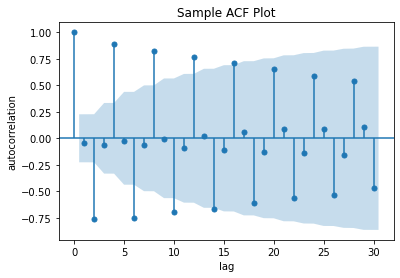

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


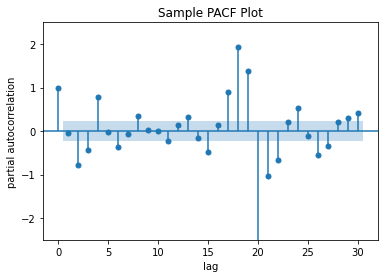

In [93]:
# Use the first differenced data to decide the order of P and Q
train00_first_diff.dropna(inplace=True)  # remove the missing values

# Plot the ACF plot
smt.graphics.tsa.plot_acf(train00_first_diff, lags=30, alpha=0.05)
plt.title('Sample ACF Plot')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Plot the PACF plot
smt.graphics.tsa.plot_pacf(train00_first_diff, lags=30, alpha=0.05)
plt.title('Sample PACF Plot')
plt.xlabel('lag')
plt.ylabel('partial autocorrelation')
plt.ylim(-2.5, 2.5)
plt.show()

Again, using the rules provided in the Tutorial, we can choose $P = 1$ as the PACF plot is positive at lag 4. For the order of the seasonal $MA$ component, the positive vlaue at lag 4 in the ACF plot suaggests that $Q$ should be equal to 0. Similarly, since both the ACF/PACF plot cut off at lag 0, the orders of $p$ and $q$ are set to be 0.

In [94]:
# Construct a SARIMA model with the selected parameters
sarima00 = SARIMAX(train00, 
                   order=(0, 1, 0),
                   seasonal_order=(1, 1, 0, 4),
                   trend='c',
                   enforce_stationarity=False,
                   enforce_invertibility=False)

# Fit the model on the traning data
model00 = sarima00.fit()

# Forecast the data after 2018
forecast00 = model00.forecast(len(valid))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


In [95]:
# Calculate the MSE and MAPE of the forecast
mse = mean_squared_error(valid, forecast00)
mape = MAPE(valid, forecast00)
aic = model00.aic

print("MSE of SARIMA(0, 1, 0)(1, 1, 0) process (without data before 2000): {:.4f}".format(mse))
print("MAPE of SARIMA(0, 1, 0)(1, 1, 0) process (without data before 2000): {:.4f} %".format(mape))
print("AIC of SARIMA(0, 1, 0)(1, 1, 0) process (without the data before 2000): {:.4f}".format(aic))

MSE of SARIMA(0, 1, 0)(1, 1, 0) process (without data before 2000): 6.6376
MAPE of SARIMA(0, 1, 0)(1, 1, 0) process (without data before 2000): 1.1180 %
AIC of SARIMA(0, 1, 0)(1, 1, 0) process (without the data before 2000): 164.2792


(2) Determine the orders of $(P, Q)$ by the ACF/PACF plot and the ones of $(p, q)$ by grid search.

In [96]:
max_p = 3
max_q = 3
aics = pd.DataFrame(np.zeros((max_p+1, max_q+1)))

# Use grid search to decide the order of p and q
for p in range(max_p+1):
    for q in range(max_q+1):
        
        sarima00 = SARIMAX(train00,                        # construct a SARIMA model 
                           order=(p, 1, q),
                           seasonal_order=(1, 1, 0, 4),
                           trend='c',
                           enforce_stationarity = False,
                           enforce_invertibility = False)
        model00 = sarima00.fit()                           # fit the model on the training data       
        aics.iloc[p, q] = model00.aic                      # extract the AIC value

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

In [97]:
# Extract the order of p and q with the minimum AIC
best_p = np.where(aics.values == aics.min().min())[0][0]
best_q = np.where(aics.values == aics.min().min())[1][0]

print("Best value of p with minimum AIC:", best_p)
print("Best value of q with minimum AIC:", best_q)

Best value of p with minimum AIC: 3
Best value of q with minimum AIC: 1


In [98]:
# Construct a SARIMA model with the selected parameters
sarima00 = SARIMAX(train00, 
                   order=(3, 1, 1),
                   seasonal_order=(1, 1, 0, 4),
                   trend='c',
                   enforce_stationarity=False,
                   enforce_invertibility=False)

# Fit the model on the traning data
model00 = sarima00.fit()

# Forecast the data after 2018
forecast00 = model00.forecast(len(valid))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


In [99]:
# Calculate the MSE and MAPE of the forecast
mse = mean_squared_error(valid, forecast00)
mape = MAPE(valid, forecast00)
aic = model00.aic

print("MSE of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): {:.4f}".format(mse))
print("MAPE of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): {:.4f}%".format(mape))
print("AIC of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): {:.4f}".format(aic))

MSE of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): 11.0837
MAPE of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): 1.5807%
AIC of SARIMA(3, 1, 1)(1, 1, 0) process (without the data before 2000): 154.5082


Since the first model has a smaller MSE/MAPE, we use the parameters selected based on the first method as the final parameters of the SARIMA process.

#### 4. Construct the final model with the selected parameters

The final parameters of the SARIMA process are selected as follows:

- Non-seasonal components: $p = 0$, $d = 1$, $q = 0$
- Seasonal components: $P = 1$, $D = 1$, $Q = 0$

In [100]:
# Construct a SARIMA model with the final parameters
sarima00 = SARIMAX(train00, 
                   order=(0, 1, 0),
                   seasonal_order=(1, 1, 0, 4),
                   trend='c',
                   enforce_stationarity=False,
                   enforce_invertibility=False)

# Fit the model on the traning data
model00 = sarima00.fit()

# Extract the fitted values of the training data
sarima00_fitted = model00.fittedvalues

# Print out the fitted results
print(model00.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               CPI   No. Observations:                   76
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 -79.140
Date:                           Sun, 28 May 2023   AIC                            164.279
Time:                                   16:54:24   BIC                            170.893
Sample:                               03-01-2000   HQIC                           166.896
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0645      0.122      0.528      0.598      -0.175       0.304
ar.S.L4       -0.3568      0.075     -4.736

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


### 5.4.2 Forecast Result

In [101]:
# Forecast the data after 2018
sarima00_forecast = model00.forecast(len(valid))

# Calculate the MSE and MAPE of the forecast
sarima00_mse = MSE(valid, sarima00_forecast)
sarima00_mape = MAPE(valid, sarima00_forecast)
sarima00_aic = model00.aic

print("MSE of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): {:.4f}".format(sarima00_mse))
print("MAPE of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): {:.4f}%".format(sarima00_mape))
print("AIC of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): {:.4f}".format(sarima00_aic))

MSE of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): 6.6376
MAPE of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): 1.1180%
AIC of SARIMA(0, 1, 0)(1, 1, 0)  process (without data before 2000): 164.2792


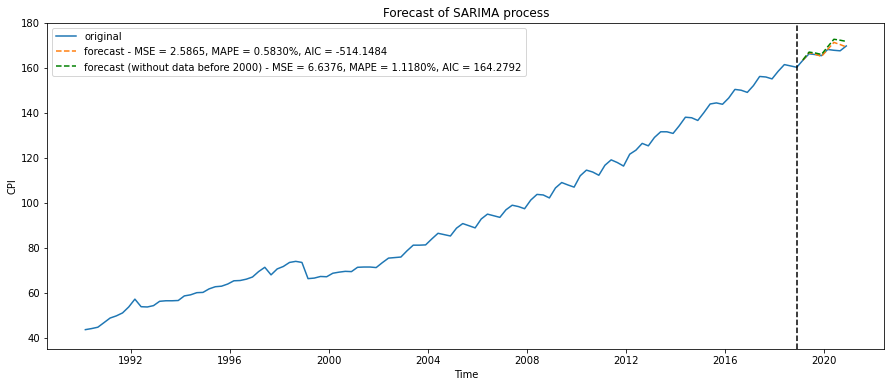

In [102]:
# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, sarima_forecast, '--')
plt.plot(valid.index, sarima00_forecast, '--g')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of SARIMA process')
# plt.legend(['original', 'forecast', 'forecast (without data before 2000)'], loc=2)
plt.legend(['original', 'forecast - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(sarima_mse, sarima_mape, sarima_aic),
            'forecast (without data before 2000) - MSE = {:.4f}, MAPE = {:.4f}%, AIC = {:.4f}'.format(sarima00_mse, sarima00_mape, sarima00_aic)], loc=2)
plt.ylim(35, 180)
plt.show()

## 5.5 Long Short-Term Memory (LSTM) Network

Not applicable because the size of the CPI data after 2000 is too small to train a stable neural network model.

# 6. Summary

## 6.1 Comparisons

We compare the forecast results obtained from different methods and select the suitable ones among them based on the MSE, MAPE, and AIC.

In [103]:
# Compare the forecast results
forecast_mse = [[tsd_mse, tsd_mape, tsd_aic, tsd00_mse, tsd00_mape, tsd00_aic],
                [lr_mse, lr_mape, lr_aic, lr00_mse, lr00_mape, lr00_aic],
                [hw_mse, hw_mape, hw_aic, hw00_mse, hw00_mape, hw00_aic],
                [sarima_mse, sarima_mape, sarima_aic, sarima00_mse, sarima00_mape, sarima00_aic],
                [lstm_mse, lstm_mape, None, None, None, None]]

forecast_summary = pd.DataFrame(forecast_mse)
forecast_summary.index = ['time series decomposition', 'linear regression', 'Holt-Winters exponential smoothing',
                          'SARIMA', 'LSTM network']
forecast_summary.columns = ['MSE', 'MAPE', 'AIC', 'MSE (after 2000)', 'MAPE (after 2000)', 'AIC (after 2000)']
forecast_summary

,MSE,MAPE,AIC,MSE (after 2000),MAPE (after 2000),AIC (after 2000)
time series decomposition,164.424251,7.672886,788.118940,5.864745,1.329022,354.321254
linear regression,164.499708,7.675533,794.107478,5.824813,1.321406,360.262076
Holt-Winters exponential smoothing,6.716901,1.106020,91.354454,5.903014,1.003652,-33.269616
SARIMA,2.586503,0.583002,-514.148423,6.637569,1.117959,164.279203
LSTM network,1.707329,0.641990,NaN,NaN,NaN,NaN


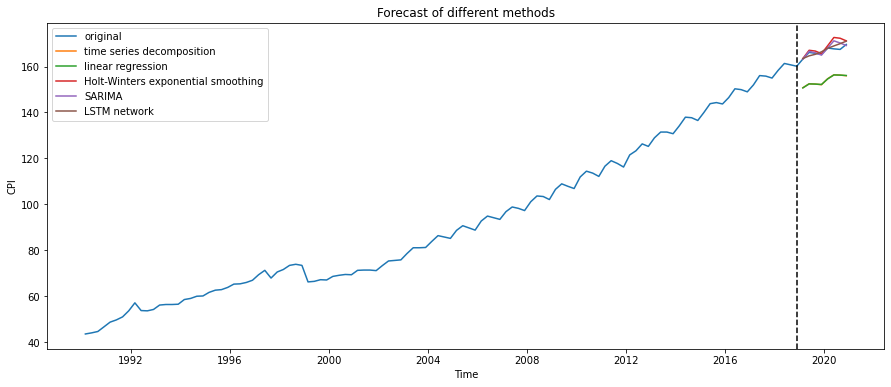

In [104]:
# Plot the forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, tsd_forecast)
plt.plot(valid.index, lr_forecast)
plt.plot(valid.index, hw_forecast)
plt.plot(valid.index, sarima_forecast)
plt.plot(valid.index, lstm_forecast)
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of different methods')
plt.legend(['original', 'time series decomposition', 'linear regression', 'Holt-Winters exponential smoothing', 'SARIMA',
            'LSTM network'], loc=2)
plt.show()

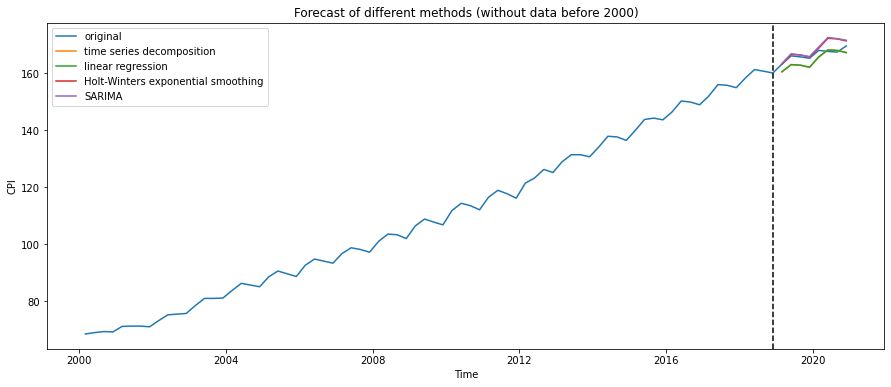

In [105]:
# Plot the forecast data (without data before 2000)
plt.figure(figsize=(15,6))
plt.plot(cpi00)
plt.plot(valid.index, tsd00_forecast)
plt.plot(valid.index, lr00_forecast)
plt.plot(valid.index, hw00_forecast)
plt.plot(valid.index, sarima00_forecast)
plt.axvline(x=train00.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of different methods (without data before 2000)')
plt.legend(['original', 'time series decomposition', 'linear regression', 'Holt-Winters exponential smoothing', 'SARIMA'],
           loc=2)
plt.show()

For time series decomposition and linear regression methods, although their forecasting ability significantly improve after the data before 2000 is removed, the results of the residual diagnostics suggest that they are not suitable for modeling the CPI data. Hence, we decide not to include them in our final model.

On the other hand, both Holt-Winters exponential smoothing and SARIMA process shows their ability to caputre the seasonality very well. They can cpature the seasonality very well and adapt to different data.

Finally, the LSTM has the lowest MSE among all of the methods.

## 6.2 Forecast Combination

We also try to forecast the data after 2017 by combining the results of the selected methods to see if the forecast accuracy can be further improved.

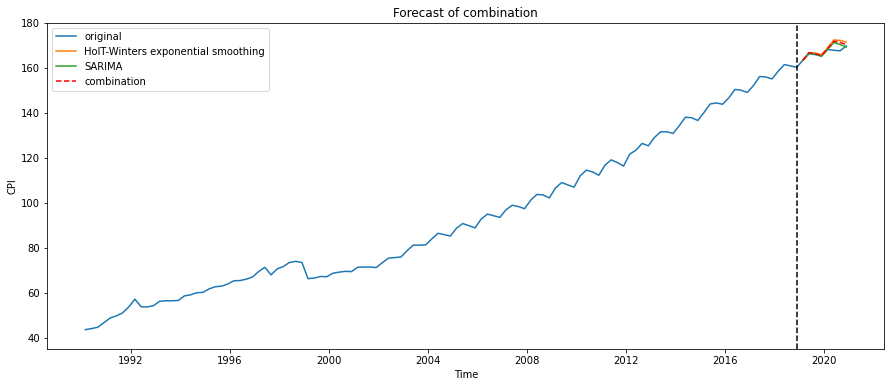

In [106]:
# Combine the forecast of the selected methods
forecast_combination = (hw00_forecast + sarima_forecast)/2

# Plot the forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi)
plt.plot(valid.index, hw00_forecast)
plt.plot(valid.index, sarima_forecast)
plt.plot(valid.index, forecast_combination, '--r')
plt.axvline(x=train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Forecast of combination')
plt.legend(['original', 'HolT-Winters exponential smoothing', 'SARIMA', 'combination'], loc=2)
plt.ylim(35, 180)
plt.show()

In [107]:
# Calculate the MSE and MAPE of the forecast
fc_mse = MSE(valid, forecast_combination)
fc_mape = MAPE(valid, forecast_combination)

print("MSE of forecast combination: {:.4f}".format(fc_mse))
print("MAPE of forecast combination: {:.4f}%".format(fc_mape))

MSE of forecast combination: 3.9027
MAPE of forecast combination: 0.7337%


The result of the forecast combination seems very promising. The values of the MSE and MAPE are both very small and much lower than the onese of the Holt-Winters exponential smoothing and SARIMA process. Although it is slightly higher than the one of the LSTM network, we consider it acceptable as the performance of the LSTM is relatively unstable. As a result, taking the average of it with the other methods may help stablize the forecast result.

# 7. Final Model

In this section, we fit the selected forecast methods using the entire `CPI_train.csv` to make forecast for  `CPI_test.csv`.

In [108]:
# Import pakcages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [109]:
# Define mean squared error
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [110]:
# Import the data
cpi_train = pd.read_csv('CPI_train.csv')
cpi_test = pd.read_csv('CPI_test.csv')
cpi_all = pd.concat((cpi_train, cpi_test))

# Set the time index
cpi_all['Quarter'] = pd.to_datetime(cpi_all['Quarter'])  # convert the Quarter column into datetime
cpi_all.set_index('Quarter', inplace=True)  # set the Quarter column as the index

cpi_train = cpi_all['CPI'][:-8]
cpi_train00 = cpi_all['CPI'][40:-8]
cpi_test = cpi_all['CPI'][-8:]

## 7.1 Holts Winter Exponential Smoothing

In [111]:
# Fit a Holt-Winters exopnential smoothing model
hw_final = ExponentialSmoothing(cpi_train00, seasonal_periods=4, trend='add', seasonal='add').fit()

# Forecast the data after 2021
hw_final_forecast = hw_final.forecast(len(cpi_test))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


## 7.2 SARIMA Process

The final parameters of the SARIMA process are selected as follows:

- Non-seasonal components: $p = 0$, $d = 1$, $q = 0$
- Seasonal components: $P = 1$, $D = 1$, $Q = 0$

In [112]:
# Construct a SARIMA model with the final parameters
sarima_final = SARIMAX(np.log(cpi_train), 
                       order=(0, 1, 0),
                       seasonal_order=(1, 1, 0, 4),
                       trend='c',
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model on the traning data
model_final = sarima_final.fit()

# Forecast the data after 2018
sarima_final_forecast = np.exp(model_final.forecast(len(cpi_test)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'


## 7.3 Forecast Combination

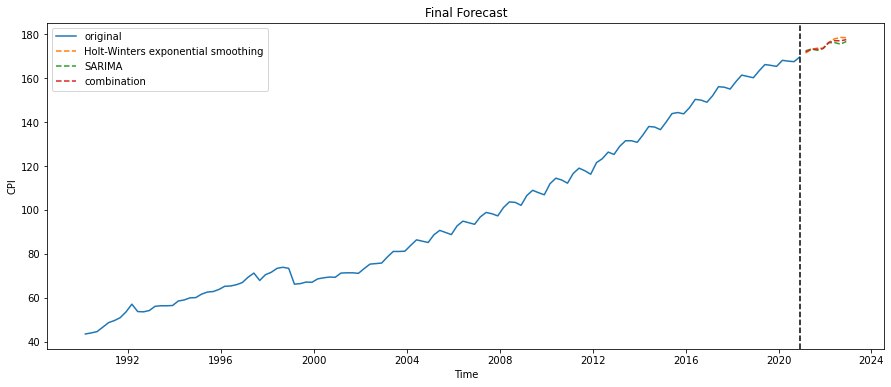

In [113]:
# Combine the forecasts
final_forecast = (hw_final_forecast + sarima_final_forecast)/2

# Plot the fitted and forecast data
plt.figure(figsize=(15,6))
plt.plot(cpi_train)
plt.plot(cpi_test.index, hw_final_forecast, '--')
plt.plot(cpi_test.index, sarima_final_forecast, '--')
plt.plot(cpi_test.index, final_forecast, '--')
plt.axvline(x=cpi_train.index[-1], color='black', ls='--')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Final Forecast')
plt.legend(['original', 'Holt-Winters exponential smoothing', 'SARIMA', 'combination'], loc=2)
plt.show()

In [114]:
# Print the final forecast
final_forecast

2021-03-01    171.908002
2021-06-01    173.127395
2021-09-01    173.149110
2021-12-01    173.489347
2022-03-01    176.175159
2022-06-01    177.020742
2022-09-01    176.975202
2022-12-01    177.494046
Freq: QS-DEC, dtype: float64

In [115]:
# Calculate the MSE and MAPE of the forecast
test_error = MSE(cpi_test, final_forecast)
print(test_error)

1973.361289354486
